# Project: Analysis of A* Search on Minneapolis City Map

### Name: Silas Kati

## Imports

In [1]:
!git clone https://github.com/aimacode/aima-python.git
%cd aima-python

C:\Users\silas\UMN\CSCI 5511 Artificial Intelligence I\Project\code\aima-python


Cloning into 'aima-python'...


In [2]:
!pip install -r requirements.txt
!git submodule init
!git submodule update

Submodule 'aima-data' (https://github.com/aimacode/aima-data.git) registered for path 'aima-data'


Submodule path 'aima-data': checked out 'f6cbea61ad0c21c6b7be826d17af5a8d3a7c2c86'


Cloning into 'C:/Users/silas/UMN/CSCI 5511 Artificial Intelligence I/Project/code/aima-python/aima-data'...


In [3]:
from search import *
from notebook import *
from utils import name, print_table
import statistics 
import pandas as pd
import numpy as np
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import lines

from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
import time

## Plotting the Minneapolis Map

In [12]:
def _show_map(graph_data, node_colors=None):
    G = nx.Graph(graph_data['graph_dict'])
    node_colors = node_colors or graph_data['node_colors']
    node_positions = graph_data['node_positions']
    node_label_pos = graph_data['node_label_positions']
    edge_weights = graph_data['edge_weights']

    # set the size of the plot
    plt.figure(figsize=(50, 80))
    # draw the graph (both nodes and edges) with locations from romania_locations
    nx.draw(G, pos={k: node_positions[k] for k in G.nodes()},
            node_color=[node_colors[node] for node in G.nodes()], linewidths=0.3, edgecolors='k')

    # draw labels for nodes
    node_label_handles = nx.draw_networkx_labels(G, pos=node_label_pos, font_size=14)

    # add a white bounding box behind the node labels
    [label.set_bbox(dict(facecolor='white', edgecolor='none')) for label in node_label_handles.values()]

    # add edge lables to the graph
    nx.draw_networkx_edge_labels(G, pos=node_positions, edge_labels=edge_weights, font_size=14)

    # add a legend
    white_circle = lines.Line2D([], [], color="white", marker='o', markersize=15, markerfacecolor="white")
    orange_circle = lines.Line2D([], [], color="orange", marker='o', markersize=15, markerfacecolor="orange")
    red_circle = lines.Line2D([], [], color="red", marker='o', markersize=15, markerfacecolor="red")
    gray_circle = lines.Line2D([], [], color="gray", marker='o', markersize=15, markerfacecolor="gray")
    green_circle = lines.Line2D([], [], color="green", marker='o', markersize=15, markerfacecolor="green")
    plt.legend((white_circle, orange_circle, red_circle, gray_circle, green_circle),
               ('Un-explored', 'Frontier', 'Currently Exploring', 'Explored', 'Final Solution'),
               numpoints=1, prop={'size': 16}, loc=(.8, .75))

    # show the plot. No need to use in notebooks. nx.draw will show the graph itself.
    plt.show()

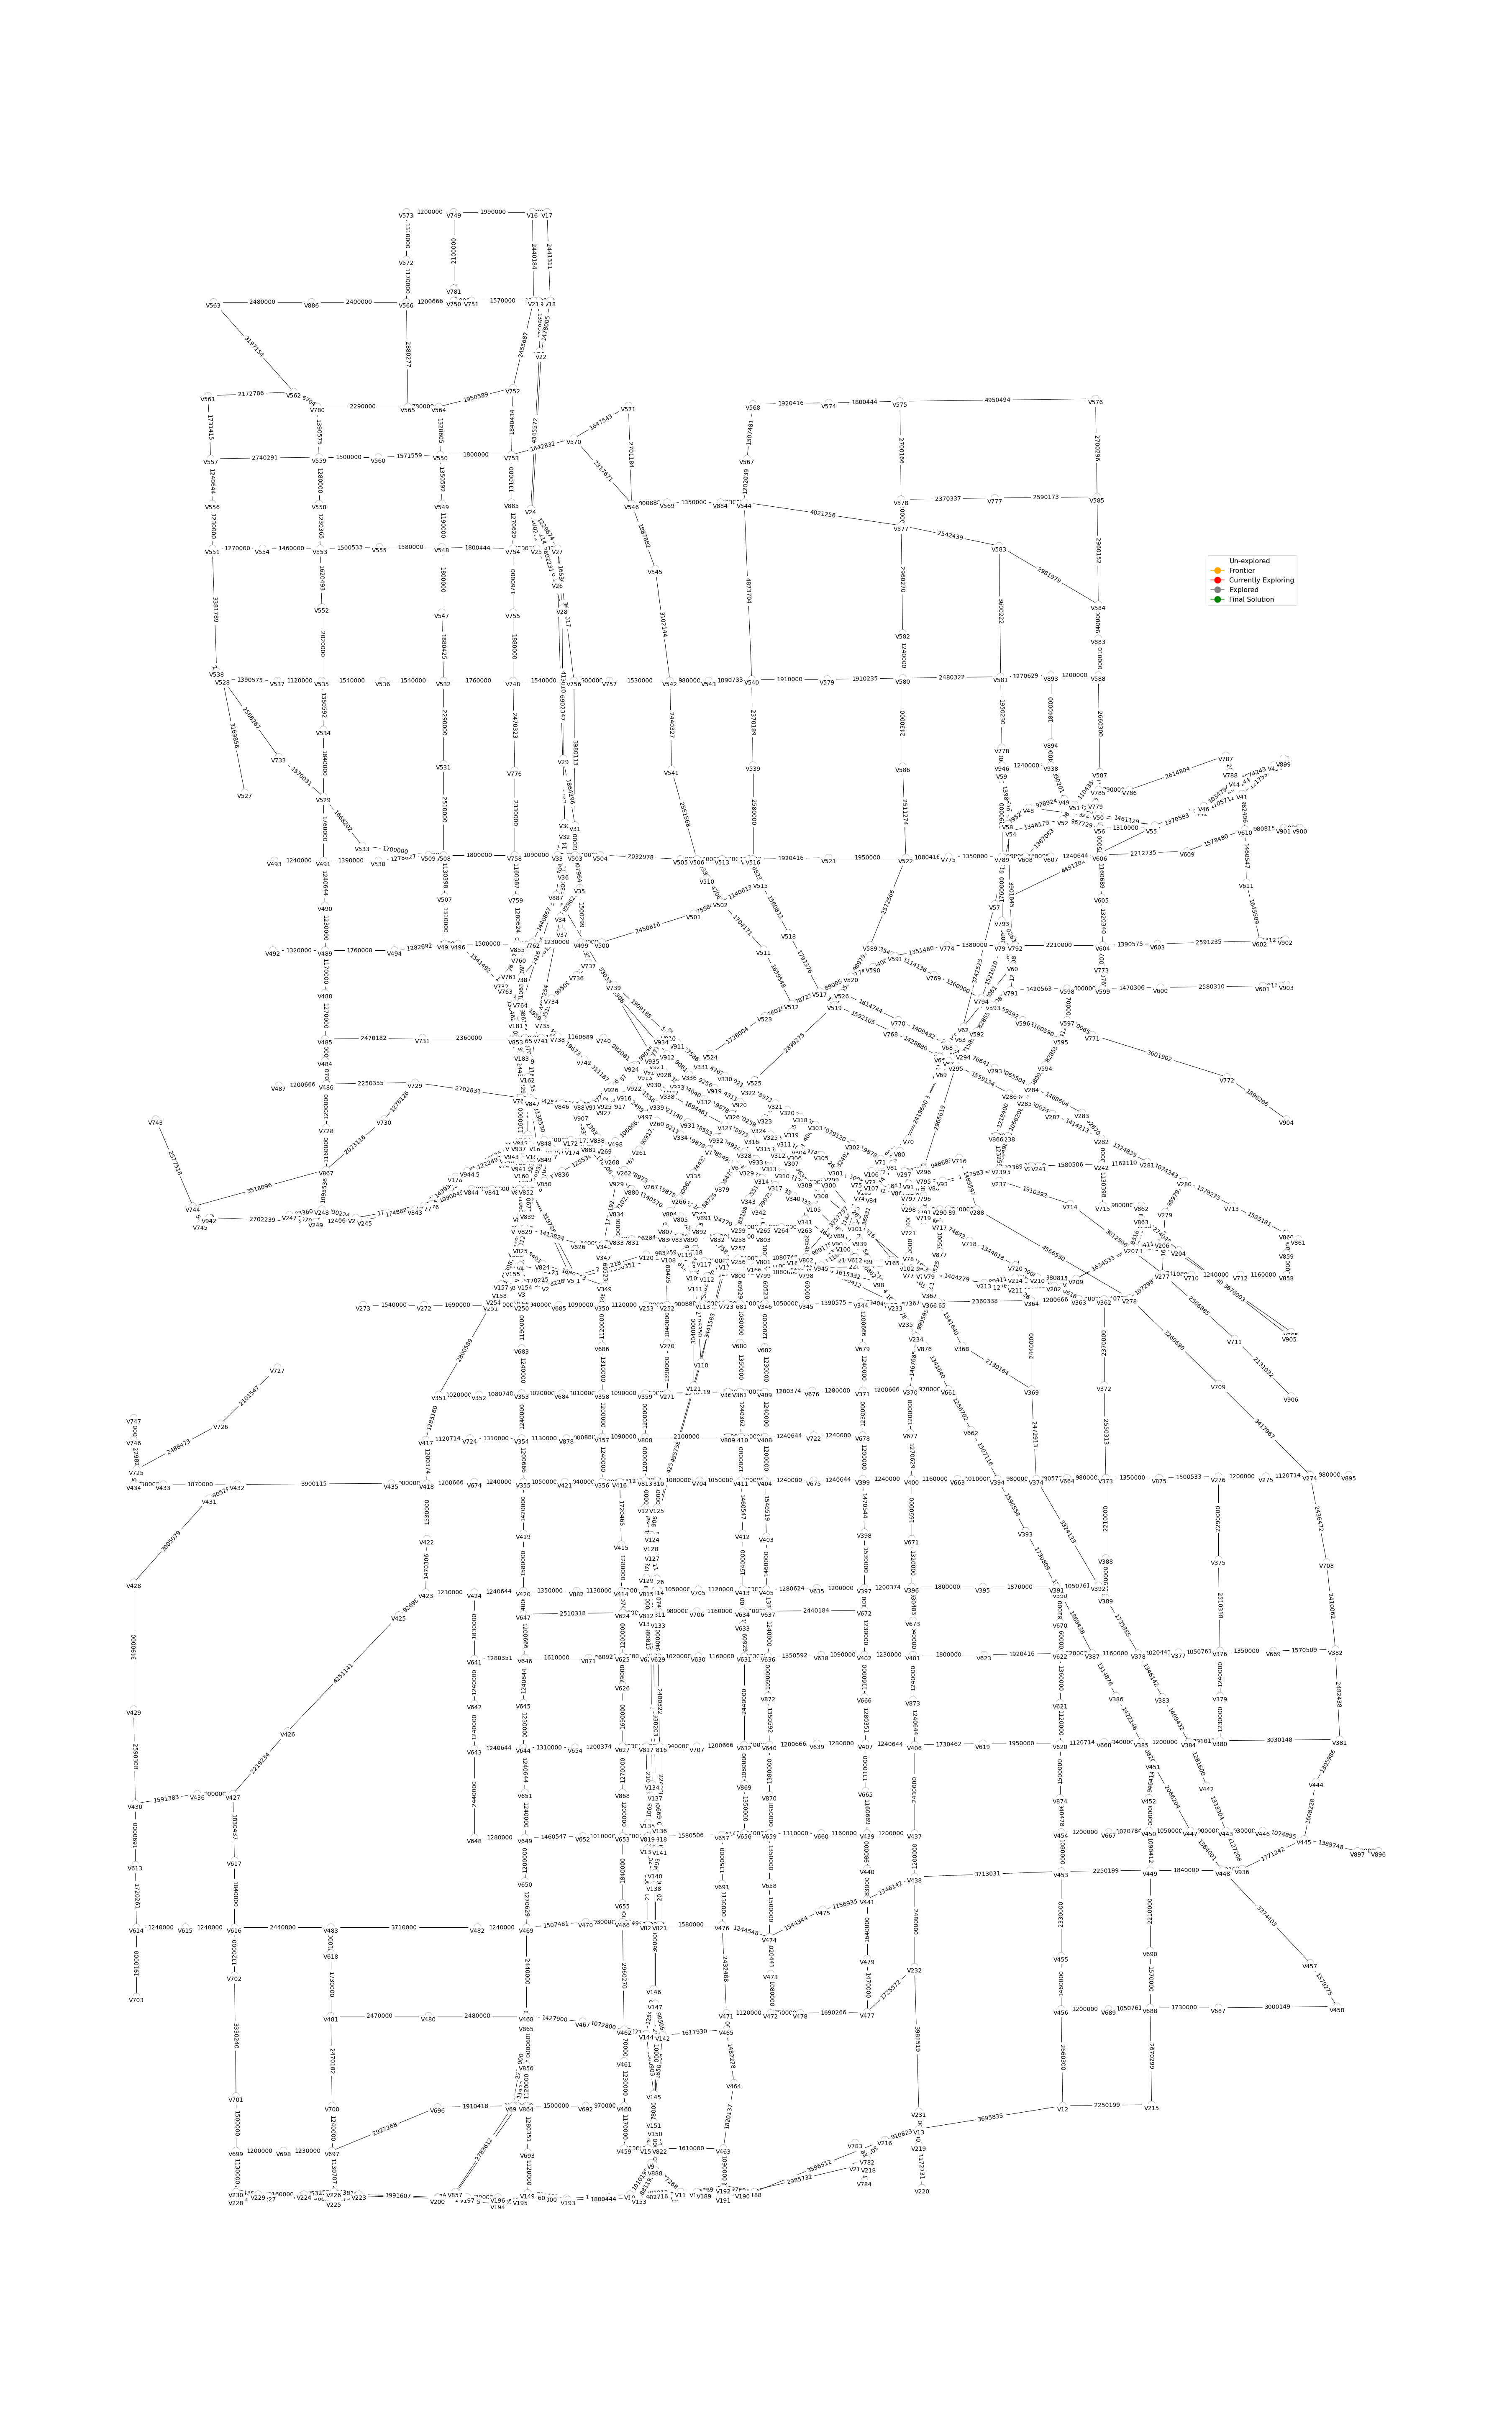

In [13]:
map_df = pd.read_csv('C:\\Users\\silas\\UMN\\CSCI 5511 Artificial Intelligence I\\Project\\code\\minneapolis.csv')
map_df['distance'] = np.sqrt( (map_df['start_x'] - map_df['end_x'])**2 + (map_df['start_y'] - map_df['end_y'])**2 )
map_df['distance'] = map_df['distance'] * 10000 # Make the distance noticable

# Clean out the non-moving edge
non_moving_lst = list()
for index, row in map_df.iterrows():
    if [row['start_x'], row['start_y']] == [row['end_x'], row['end_y']]:
        non_moving_lst.append(index)
for idx in non_moving_lst:
    map_df = map_df.drop(index=idx)

# Append every vertex a list
vertices_lst = list()
for index, row in map_df.iterrows():
    vertices_lst.append((row['start_x'], row['start_y']))
    vertices_lst.append((row['end_x'], row['end_y']))
    
# Remove duplicates of vertices
vertices_lst_no_dup = []
[vertices_lst_no_dup.append(x) for x in vertices_lst if x not in vertices_lst_no_dup]

# Name each vectex and add them to the dictionary
vertices = dict()
for i in range(len(vertices_lst_no_dup)):
    vertices['V' + str(i+1)] = vertices_lst_no_dup[i]

minneapolis_map = UndirectedGraph(graph_dict=None)

# helper function
def get_key(val):
    for key, value in vertices.items():
         if val == value:
             return key

# connect edge between vertices
for index, row in map_df.iterrows():
    start = (row['start_x'], row['start_y'])
    end = (row['end_x'], row['end_y'])
    minneapolis_map.connect(get_key(start), get_key(end), int(row['distance']))

# Log their individual locations 
minneapolis_map.locations = vertices

# node colors, node positions and node label positions
node_colors = {node: 'white' for node in minneapolis_map.locations.keys()}
node_positions = minneapolis_map.locations
node_label_pos = { k:[v[0],v[1]-10]  for k,v in minneapolis_map.locations.items() }
edge_weights = {(k, k2) : v2 for k, v in minneapolis_map.graph_dict.items() for k2, v2 in v.items()}

minneapolis_graph_data = {   'graph_dict' : minneapolis_map.graph_dict,
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                        'edge_weights': edge_weights
                    }
_show_map(minneapolis_graph_data)

# Limitation: don't know about which coordinate system they use, could be inaccurate.

In [14]:
map_df # Full map data

way  start_x  start_y  end_x  end_y      distance
0       1     1121     7568   1042   7545  8.228001e+05
1       1     1042     7545    982   7530  6.184658e+05
2       2      982     7530    979   7601  7.106335e+05
3       1     1106     7568    979   7601  1.312174e+06
4       2     1522     7879   1455   7920  7.854935e+05
...   ...      ...      ...    ...    ...           ...
1352    1     1826     7710   1740   7601  1.388416e+06
1353    1     1837     7669   1740   7601  1.184610e+06
1354    2     2197     8966   2197   8977  1.100000e+05
1355    2     2197     9026   2197   8977  4.900000e+05
1356    2     2321     8977   2197   8977  1.240000e+06

[1354 rows x 6 columns]

In [15]:
vertices # Coordinate of every vertex

{'V1': (1121.0, 7568.0),
 'V2': (1042.0, 7545.0),
 'V3': (982.0, 7530.0),
 'V4': (979.0, 7601.0),
 'V5': (1106.0, 7568.0),
 'V6': (1522.0, 7879.0),
 'V7': (1455.0, 7920.0),
 'V8': (1369.0, 5040.0),
 'V9': (1309.0, 5130.0),
 'V10': (1256.0, 5044.0),
 'V11': (1384.0, 5051.0),
 'V12': (2351.0, 5288.0),
 'V13': (1987.0, 5224.0),
 'V14': (937.0, 7883.0),
 'V15': (862.0, 7860.0),
 'V16': (1009.0, 10500.0),
 'V17': (1046.0, 10500.0),
 'V18': (1054.0, 10256.0),
 'V19': (1024.0, 10256.0),
 'V20': (1027.0, 10117.0),
 'V21': (1012.0, 10256.0),
 'V22': (1031.0, 10110.0),
 'V23': (1009.0, 9679.0),
 'V24': (1005.0, 9683.0),
 'V25': (1020.0, 9574.0),
 'V26': (1073.0, 9480.0),
 'V27': (1073.0, 9574.0),
 'V28': (1084.0, 9409.0),
 'V29': (1087.0, 8996.0),
 'V30': (1091.0, 8820.0),
 'V31': (1117.0, 8812.0),
 'V32': (1091.0, 8790.0),
 'V33': (1073.0, 8730.0),
 'V34': (1080.0, 8561.0),
 'V35': (1129.0, 8640.0),
 'V36': (1087.0, 8678.0),
 'V37': (1084.0, 8520.0),
 'V38': (982.0, 8396.0),
 'V39': (1001.0, 81

In [16]:
minneapolis_map.get("V1") # Info about connection between vertices

{'V2': 822800, 'V108': 2396351, 'V160': 3197889}

## Comparing successors, goal tests, states, and path cost

In [17]:
# override compare_searchers in the source code to print out path cost
def compare_searchers(problems, header,
                      searchers=[breadth_first_graph_search,
                                 depth_first_graph_search,
                                 uniform_cost_search,
                                 astar_search]):
    def do(searcher, problem):
        start_time = time.time()
        path_indx = 0
        p = InstrumentedProblem(problem)
        x = searcher(p)
        passed_time = time.time() - start_time 
        return p, x.path_cost, passed_time 

    table = [[name(s)] + [do(s, p) for p in problems] for s in searchers]

    print_table(table, header)
    print ("\t\t\t", end=" ")

    # (optionaly) Let's loop through the table and calculate some stats! 
    for i in range(len(problems)):

        mylist = []
        for j in range(len(searchers)):
                #solution = table[j+1][i+1][0]
                path_cost = table[j+1][i+1][1]
                mylist.append(path_cost)

        # compute statistics
        print("\tmean: %.4f std: %.4f" %(mean(mylist), statistics.stdev(mylist)), end=" ")

    print("")

    return table 

In [20]:
def manhattan_distance(x, y):
    return sum(abs(_x - _y) for _x, _y in zip(x, y))

def chebyshev_distance(x, y):
    return max(abs(_x - _y) for _x, _y in zip(x, y))

class GraphProblem(Problem):
    """The problem of searching a graph from one node to another."""

    def __init__(self, initial, goal, graph):
        super().__init__(initial, goal)
        self.graph = graph

    def actions(self, A):
        """The actions at a graph node are just its neighbors."""
        return list(self.graph.get(A).keys())

    def result(self, state, action):
        """The result of going to a neighbor is just that neighbor."""
        return action

    def path_cost(self, cost_so_far, A, action, B):
        return cost_so_far + (self.graph.get(A, B) or np.inf)

    def find_min_edge(self):
        """Find minimum value of edges."""
        m = np.inf
        for d in self.graph.graph_dict.values():
            local_min = min(d.values())
            m = min(m, local_min)

        return m

    def h(self, node):
        """h function is straight-line distance from a node's state to goal."""
        locs = getattr(self.graph, 'locations', None)
        if locs:
            if type(node) is str:
                return int(distance(locs[node], locs[self.goal]))

            return int(distance(locs[node.state], locs[self.goal]))
        else:
            return np.inf
    
    def manhattan_h(self, node):
        """h function is l1 norm distance from a node's state to goal."""
        locs = getattr(self.graph, 'locations', None)
        if locs:
            if type(node) is str:
                return int(manhattan_distance(locs[node], locs[self.goal]))

            return int(manhattan_distance(locs[node.state], locs[self.goal]))
        else:
            return np.inf

    def chebyshev_h(self, node):
        """h function is l1 norm distance from a node's state to goal."""
        locs = getattr(self.graph, 'locations', None)
        if locs:
            if type(node) is str:
                return int(chebyshev_distance(locs[node], locs[self.goal]))

            return int(chebyshev_distance(locs[node.state], locs[self.goal]))
        else:
            return np.inf

def manhattan_astar_search(problem, h=None, display=False):
    """A* search is best-first graph search with f(n) = g(n)+h(n).
    You need to specify the h function when you call astar_search, or
    else in your Problem subclass."""
    h = memoize(problem.manhattan_h, 'h')
    return best_first_graph_search(problem, lambda n: n.path_cost + h(n), display)

def chebyshev_astar_search(problem, h=None, display=False):
    """A* search is best-first graph search with f(n) = g(n)+h(n).
    You need to specify the h function when you call astar_search, or
    else in your Problem subclass."""
    h = memoize(problem.chebyshev_h, 'h')
    return best_first_graph_search(problem, lambda n: n.path_cost + h(n), display)

def weighted_astar_search(problem, h=None, display=False):
    """A* search is best-first graph search with f(n) = g(n)+h(n).
    You need to specify the h function when you call astar_search, or
    else in your Problem subclass."""
    h = memoize(h or problem.h, 'h')
    return best_first_graph_search(problem, lambda n: n.path_cost + 2 * h(n), display)

In [21]:
%%time
compare_searchers(problems=[GraphProblem('V1', 'V326', minneapolis_map),
                            GraphProblem('V72', 'V852', minneapolis_map),
                            GraphProblem('V579', 'V944', minneapolis_map)],
                  header=['Searcher', 'minneapolis_map(V1, V326)',
                          'minneapolis_map(V72, V852)',
                          'minneapolis_map(V579, V944)'],
                  searchers=[astar_search,
                             manhattan_astar_search,
                             chebyshev_astar_search,
                             weighted_astar_search
                             ])

Searcher                 minneapolis_map(V1, V326)                                minneapolis_map(V72, V852)                                minneapolis_map(V579, V944)                            
astar_search             (< 194/ 195/ 580/V326>, 8294046, 0.006094455718994141)   (< 393/ 394/1187/V852>, 11463314, 0.012166738510131836)   (< 487/ 488/1418/V944>, 21318334, 0.01827096939086914) 
manhattan_astar_search   (< 194/ 195/ 580/V326>, 8294046, 0.008512020111083984)   (< 393/ 394/1187/V852>, 11463314, 0.019789457321166992)   (< 487/ 488/1418/V944>, 21318334, 0.021411418914794922)
chebyshev_astar_search   (< 194/ 195/ 580/V326>, 8294046, 0.008108139038085938)   (< 393/ 394/1187/V852>, 11463314, 0.017325401306152344)   (< 487/ 488/1418/V944>, 21318334, 0.021726131439208984)
weighted_astar_search    (< 194/ 195/ 580/V326>, 8294046, 0.008705377578735352)   (< 392/ 393/1184/V852>, 11463314, 0.017956972122192383)   (< 487/ 488/1418/V944>, 21318334, 0.02158522605895996) 
			 	mean: 8294046.0

[['Searcher',
  'minneapolis_map(V1, V326)',
  'minneapolis_map(V72, V852)',
  'minneapolis_map(V579, V944)'],
 ['astar_search',
  (< 194/ 195/ 580/V326>, 8294046, 0.006094455718994141),
  (< 393/ 394/1187/V852>, 11463314, 0.012166738510131836),
  (< 487/ 488/1418/V944>, 21318334, 0.01827096939086914)],
 ['manhattan_astar_search',
  (< 194/ 195/ 580/V326>, 8294046, 0.008512020111083984),
  (< 393/ 394/1187/V852>, 11463314, 0.019789457321166992),
  (< 487/ 488/1418/V944>, 21318334, 0.021411418914794922)],
 ['chebyshev_astar_search',
  (< 194/ 195/ 580/V326>, 8294046, 0.008108139038085938),
  (< 393/ 394/1187/V852>, 11463314, 0.017325401306152344),
  (< 487/ 488/1418/V944>, 21318334, 0.021726131439208984)],
 ['weighted_astar_search',
  (< 194/ 195/ 580/V326>, 8294046, 0.008705377578735352),
  (< 392/ 393/1184/V852>, 11463314, 0.017956972122192383),
  (< 487/ 488/1418/V944>, 21318334, 0.02158522605895996)]]

## Calculating for one vertex to all vertices

In [23]:
as_cost = 0
mas_cost = 0
cas_cost = 0
was_cost = 0

as_time = 0
mas_time = 0
cas_time = 0
was_time = 0

as_succs = 0
mas_succs = 0
cas_succs = 0
was_succs = 0

as_goal_tests = 0
mas_goal_tests = 0
cas_goal_tests = 0
was_goal_tests = 0

as_states = 0
mas_states = 0
cas_states = 0
was_states = 0


for i in range(len(vertices)):  
    vertex1 = "V" 
    vertex1 += str(i+1)
#   for j in range(91):
#     vertex2 = "V"
#     vertex2 += str(j+1)

    t = compare_searchers(problems=[GraphProblem('V1', vertex1, minneapolis_map)],
                        header=['Searcher', 'minneapolis_map(' + 'V1' + ', ' + vertex1 + ')'],
                        searchers=[ astar_search,
                                    manhattan_astar_search,
                                    chebyshev_astar_search,
                                    weighted_astar_search])

    a = t[1]
    (z, costt, timee) = a[1]
    as_cost += costt 
    as_time += timee 
    as_succs += z.succs
    as_goal_tests += z.goal_tests
    as_states += z.states

    mas = t[2]
    (z, costt, timee) = mas[1]
    mas_cost += costt 
    mas_time += timee 
    mas_succs += z.succs
    mas_goal_tests += z.goal_tests
    mas_states += z.states

    cas = t[3]
    (z, costt, timee) = cas[1]
    cas_cost += costt 
    cas_time += timee 
    cas_succs += z.succs 
    cas_goal_tests += z.goal_tests
    cas_states += z.states 

    was = t[4]
    (z, costt, timee) = was[1]
    was_cost += costt 
    was_time += timee 
    was_succs += z.succs
    was_goal_tests += z.goal_tests
    was_states += z.states


print('as_cost: ' + str(as_cost))
print('as_time: ' + str(as_time))
print('as_succs: ' + str(as_succs))
print('as_goal_tests: ' + str(as_goal_tests))
print('as_states: ' + str(as_states))

print('mas_cost: ' + str(mas_cost))
print('mas_time: ' + str(mas_time))
print('mas_succs: ' + str(mas_succs))
print('mas_goal_tests: ' + str(mas_goal_tests))
print('mas_states: ' + str(mas_states))

print('cas_cost: ' + str(cas_cost))
print('cas_time: ' + str(cas_time))
print('cas_succs: ' + str(cas_succs))
print('cas_goal_tests: ' + str(cas_goal_tests))
print('cas_states: ' + str(cas_states))

print('was_cost: ' + str(was_cost))
print('was_time: ' + str(was_time))
print('was_succs: ' + str(was_succs))
print('was_goal_tests: ' + str(was_goal_tests))
print('was_states: ' + str(was_states))

Searcher                 minneapolis_map(V1, V1)      
astar_search             (<   0/   1/   0/V1>, 0, 0.0)
manhattan_astar_search   (<   0/   1/   0/V1>, 0, 0.0)
chebyshev_astar_search   (<   0/   1/   0/V1>, 0, 0.0)
weighted_astar_search    (<   0/   1/   0/V1>, 0, 0.0)
			 	mean: 0.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V2)           
astar_search             (<   1/   2/   3/V2>, 822800, 0.0)
manhattan_astar_search   (<   1/   2/   3/V2>, 822800, 0.0)
chebyshev_astar_search   (<   1/   2/   3/V2>, 822800, 0.0)
weighted_astar_search    (<   1/   2/   3/V2>, 822800, 0.0)
			 	mean: 822800.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V3)            
astar_search             (<   3/   4/   9/V3>, 1441265, 0.0)
manhattan_astar_search   (<   3/   4/   9/V3>, 1441265, 0.0)
chebyshev_astar_search   (<   3/   4/   9/V3>, 1441265, 0.0)
weighted_astar_search    (<   3/   4/   9/V3>, 1441265, 0.0)
			 	mean: 1441265.0000 std: 0.0000 
Searcher        

Searcher                 minneapolis_map(V1, V21)                             
astar_search             (< 862/ 863/2493/V21>, 27344274, 0.04046797752380371)
manhattan_astar_search   (< 862/ 863/2493/V21>, 27344274, 0.04056143760681152)
chebyshev_astar_search   (< 862/ 863/2493/V21>, 27344274, 0.04006505012512207)
weighted_astar_search    (< 862/ 863/2493/V21>, 27344274, 0.04106593132019043)
			 	mean: 27344274.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V22)                              
astar_search             (< 840/ 841/2435/V22>, 26473852, 0.040719032287597656)
manhattan_astar_search   (< 840/ 841/2435/V22>, 26473852, 0.039052724838256836)
chebyshev_astar_search   (< 840/ 841/2435/V22>, 26473852, 0.0395665168762207)  
weighted_astar_search    (< 840/ 841/2435/V22>, 26473852, 0.04007148742675781) 
			 	mean: 26473852.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V23)                              
astar_search             (< 722/ 723/2114/V23>, 2

Searcher                 minneapolis_map(V1, V42)                             
astar_search             (< 749/ 750/2181/V42>, 23142126, 0.03704380989074707)
manhattan_astar_search   (< 749/ 750/2181/V42>, 23142126, 0.03941464424133301)
chebyshev_astar_search   (< 749/ 750/2181/V42>, 23142126, 0.03487586975097656)
weighted_astar_search    (< 749/ 750/2181/V42>, 23142126, 0.03564143180847168)
			 	mean: 23142126.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V43)                             
astar_search             (< 810/ 811/2355/V43>, 25435812, 0.03904318809509277)
manhattan_astar_search   (< 810/ 811/2355/V43>, 25435812, 0.03813290596008301)
chebyshev_astar_search   (< 810/ 811/2355/V43>, 25435812, 0.03790998458862305)
weighted_astar_search    (< 810/ 811/2355/V43>, 25435812, 0.04204559326171875)
			 	mean: 25435812.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V44)                              
astar_search             (< 788/ 789/2293/V44>, 246373

Searcher                 minneapolis_map(V1, V63)                              
astar_search             (< 459/ 460/1380/V63>, 13537816, 0.023029088973999023)
manhattan_astar_search   (< 459/ 460/1380/V63>, 13537816, 0.022245407104492188)
chebyshev_astar_search   (< 459/ 460/1380/V63>, 13537816, 0.022544145584106445)
weighted_astar_search    (< 459/ 460/1380/V63>, 13537816, 0.022756338119506836)
			 	mean: 13537816.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V64)                              
astar_search             (< 447/ 448/1342/V64>, 13167898, 0.021535396575927734)
manhattan_astar_search   (< 447/ 448/1342/V64>, 13167898, 0.021043062210083008)
chebyshev_astar_search   (< 447/ 448/1342/V64>, 13167898, 0.021470069885253906)
weighted_astar_search    (< 447/ 448/1342/V64>, 13167898, 0.021523237228393555)
			 	mean: 13167898.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V65)                              
astar_search             (< 436/ 437/1309/V6

Searcher                 minneapolis_map(V1, V84)                             
astar_search             (< 225/ 226/ 677/V84>, 8719410, 0.01007986068725586) 
manhattan_astar_search   (< 225/ 226/ 677/V84>, 8719410, 0.01064753532409668) 
chebyshev_astar_search   (< 225/ 226/ 677/V84>, 8719410, 0.009109735488891602)
weighted_astar_search    (< 225/ 226/ 677/V84>, 8719410, 0.013028621673583984)
			 	mean: 8719410.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V85)                             
astar_search             (< 298/ 299/ 898/V85>, 9798113, 0.018030643463134766)
manhattan_astar_search   (< 298/ 299/ 898/V85>, 9798113, 0.019016027450561523)
chebyshev_astar_search   (< 298/ 299/ 898/V85>, 9798113, 0.016518354415893555)
weighted_astar_search    (< 298/ 299/ 898/V85>, 9798113, 0.014022588729858398)
			 	mean: 9798113.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V86)                             
astar_search             (< 271/ 272/ 812/V86>, 9387017, 

Searcher                 minneapolis_map(V1, V107)                              
astar_search             (< 310/ 311/ 932/V107>, 10141083, 0.026044845581054688)
manhattan_astar_search   (< 310/ 311/ 932/V107>, 10141083, 0.020598411560058594)
chebyshev_astar_search   (< 310/ 311/ 932/V107>, 10141083, 0.014513492584228516)
weighted_astar_search    (< 310/ 311/ 932/V107>, 10141083, 0.015116691589355469)
			 	mean: 10141083.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V108)            
astar_search             (<  11/  12/  34/V108>, 2396351, 0.0)
manhattan_astar_search   (<  11/  12/  34/V108>, 2396351, 0.0)
chebyshev_astar_search   (<  11/  12/  34/V108>, 2396351, 0.0)
weighted_astar_search    (<  11/  12/  34/V108>, 2396351, 0.0)
			 	mean: 2396351.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V109)                              
astar_search             (<  20/  21/  61/V109>, 3194473, 0.0)                  
manhattan_astar_search   (<  20/  21/  61/V

Searcher                 minneapolis_map(V1, V126)                              
astar_search             (< 417/ 418/1248/V126>, 12614856, 0.020679473876953125)
manhattan_astar_search   (< 417/ 418/1248/V126>, 12614856, 0.01957845687866211) 
chebyshev_astar_search   (< 417/ 418/1248/V126>, 12614856, 0.01809215545654297) 
weighted_astar_search    (< 417/ 418/1248/V126>, 12614856, 0.02160501480102539) 
			 	mean: 12614856.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V127)                              
astar_search             (< 401/ 402/1199/V127>, 12140326, 0.019187211990356445)
manhattan_astar_search   (< 401/ 402/1199/V127>, 12140326, 0.020023822784423828)
chebyshev_astar_search   (< 401/ 402/1199/V127>, 12140326, 0.0195314884185791)  
weighted_astar_search    (< 401/ 402/1199/V127>, 12140326, 0.018523693084716797)
			 	mean: 12140326.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V128)                              
astar_search             (< 342/ 

Searcher                 minneapolis_map(V1, V146)                              
astar_search             (< 741/ 742/2160/V146>, 22984087, 0.03484082221984863) 
manhattan_astar_search   (< 741/ 742/2160/V146>, 22984087, 0.034560441970825195)
chebyshev_astar_search   (< 741/ 742/2160/V146>, 22984087, 0.035685062408447266)
weighted_astar_search    (< 741/ 742/2160/V146>, 22984087, 0.036800384521484375)
			 	mean: 22984087.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V147)                              
astar_search             (< 761/ 762/2212/V147>, 23672431, 0.05633974075317383) 
manhattan_astar_search   (< 761/ 762/2212/V147>, 23672431, 0.035691022872924805)
chebyshev_astar_search   (< 761/ 762/2212/V147>, 23672431, 0.03714799880981445) 
weighted_astar_search    (< 761/ 762/2212/V147>, 23672431, 0.03823542594909668) 
			 	mean: 23672431.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V148)                             
astar_search             (< 860/ 8

Searcher                 minneapolis_map(V1, V166)                              
astar_search             (<  43/  44/ 130/V166>, 4606688, 0.0010006427764892578)
manhattan_astar_search   (<  43/  44/ 130/V166>, 4606688, 0.0009970664978027344)
chebyshev_astar_search   (<  43/  44/ 130/V166>, 4606688, 0.001508951187133789) 
weighted_astar_search    (<  43/  44/ 130/V166>, 4606688, 0.0010094642639160156)
			 	mean: 4606688.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V167)                              
astar_search             (<  31/  32/  93/V167>, 4149633, 0.0)                  
manhattan_astar_search   (<  31/  32/  93/V167>, 4149633, 0.0009970664978027344)
chebyshev_astar_search   (<  31/  32/  93/V167>, 4149633, 0.0009992122650146484)
weighted_astar_search    (<  31/  32/  93/V167>, 4149633, 0.0005040168762207031)
			 	mean: 4149633.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V168)                             
astar_search             (< 254/ 255

Searcher                 minneapolis_map(V1, V187)                              
astar_search             (< 901/ 902/2600/V187>, 29539699, 0.0413362979888916)  
manhattan_astar_search   (< 901/ 902/2600/V187>, 29539699, 0.042485952377319336)
chebyshev_astar_search   (< 901/ 902/2600/V187>, 29539699, 0.040808916091918945)
weighted_astar_search    (< 901/ 902/2600/V187>, 29539699, 0.04187774658203125) 
			 	mean: 29539699.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V188)                             
astar_search             (< 924/ 925/2659/V188>, 30999699, 0.042236328125)     
manhattan_astar_search   (< 924/ 925/2659/V188>, 30999699, 0.04277944564819336)
chebyshev_astar_search   (< 924/ 925/2659/V188>, 30999699, 0.04158186912536621)
weighted_astar_search    (< 924/ 925/2659/V188>, 30999699, 0.04317164421081543)
			 	mean: 30999699.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V189)                              
astar_search             (< 903/ 904/2

Searcher                 minneapolis_map(V1, V206)                              
astar_search             (< 526/ 527/1567/V206>, 15540277, 0.026915788650512695)
manhattan_astar_search   (< 526/ 527/1567/V206>, 15540277, 0.024157285690307617)
chebyshev_astar_search   (< 526/ 527/1567/V206>, 15540277, 0.025219440460205078)
weighted_astar_search    (< 526/ 527/1567/V206>, 15540277, 0.02603912353515625) 
			 	mean: 15540277.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V207)                              
astar_search             (< 499/ 500/1491/V207>, 14736163, 0.024129152297973633)
manhattan_astar_search   (< 499/ 500/1491/V207>, 14736163, 0.023572206497192383)
chebyshev_astar_search   (< 499/ 500/1491/V207>, 14736163, 0.025135517120361328)
weighted_astar_search    (< 499/ 500/1491/V207>, 14736163, 0.025035619735717773)
			 	mean: 14736163.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V208)                              
astar_search             (< 518/ 

Searcher                 minneapolis_map(V1, V226)                             
astar_search             (< 907/ 908/2613/V226>, 29783890, 0.04178881645202637)
manhattan_astar_search   (< 907/ 908/2613/V226>, 29783890, 0.04297518730163574)
chebyshev_astar_search   (< 907/ 908/2613/V226>, 29783890, 0.04160809516906738)
weighted_astar_search    (< 907/ 908/2613/V226>, 29783890, 0.04363512992858887)
			 	mean: 29783890.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V227)                              
astar_search             (< 912/ 913/2628/V227>, 30113168, 0.04205441474914551) 
manhattan_astar_search   (< 912/ 913/2628/V227>, 30113168, 0.04477810859680176) 
chebyshev_astar_search   (< 912/ 913/2628/V227>, 30113168, 0.0420689582824707)  
weighted_astar_search    (< 912/ 913/2628/V227>, 30113168, 0.044072866439819336)
			 	mean: 30113168.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V228)                              
astar_search             (< 897/ 898/2

Searcher                 minneapolis_map(V1, V246)                             
astar_search             (< 280/ 281/ 835/V246>, 9529265, 0.012286663055419922)
manhattan_astar_search   (< 280/ 281/ 835/V246>, 9529265, 0.014121532440185547)
chebyshev_astar_search   (< 280/ 281/ 835/V246>, 9529265, 0.01207423210144043) 
weighted_astar_search    (< 280/ 281/ 835/V246>, 9529265, 0.013126134872436523)
			 	mean: 9529265.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V247)                              
astar_search             (< 312/ 313/ 937/V247>, 10173773, 0.014900445938110352)
manhattan_astar_search   (< 312/ 313/ 937/V247>, 10173773, 0.014357805252075195)
chebyshev_astar_search   (< 312/ 313/ 937/V247>, 10173773, 0.014083147048950195)
weighted_astar_search    (< 312/ 313/ 937/V247>, 10173773, 0.01476287841796875) 
			 	mean: 10173773.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V248)                             
astar_search             (< 269/ 270/ 80

Searcher                 minneapolis_map(V1, V270)                              
astar_search             (< 112/ 113/ 330/V270>, 6541265, 0.0040018558502197266)
manhattan_astar_search   (< 112/ 113/ 330/V270>, 6541265, 0.0030145645141601562)
chebyshev_astar_search   (< 112/ 113/ 330/V270>, 6541265, 0.004004955291748047) 
weighted_astar_search    (< 112/ 113/ 330/V270>, 6541265, 0.003505229949951172) 
			 	mean: 6541265.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V271)                             
astar_search             (< 177/ 178/ 527/V271>, 7931265, 0.00699925422668457) 
manhattan_astar_search   (< 177/ 178/ 527/V271>, 7931265, 0.006508588790893555)
chebyshev_astar_search   (< 177/ 178/ 527/V271>, 7931265, 0.007517576217651367)
weighted_astar_search    (< 177/ 178/ 527/V271>, 7931265, 0.007504463195800781)
			 	mean: 7931265.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V272)                              
astar_search             (<  30/  31/  9

Searcher                 minneapolis_map(V1, V290)                              
astar_search             (< 386/ 387/1150/V290>, 11702597, 0.018552064895629883)
manhattan_astar_search   (< 386/ 387/1150/V290>, 11702597, 0.019089698791503906)
chebyshev_astar_search   (< 386/ 387/1150/V290>, 11702597, 0.018091440200805664)
weighted_astar_search    (< 386/ 387/1150/V290>, 11702597, 0.01885080337524414) 
			 	mean: 11702597.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V291)                              
astar_search             (< 365/ 366/1090/V291>, 11292597, 0.018901348114013672)
manhattan_astar_search   (< 365/ 366/1090/V291>, 11292597, 0.016836881637573242)
chebyshev_astar_search   (< 365/ 366/1090/V291>, 11292597, 0.017780065536499023)
weighted_astar_search    (< 365/ 366/1090/V291>, 11292597, 0.018140554428100586)
			 	mean: 11292597.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V292)                              
astar_search             (< 356/ 

Searcher                 minneapolis_map(V1, V316)                             
astar_search             (< 216/ 217/ 650/V316>, 8619995, 0.009341239929199219)
manhattan_astar_search   (< 216/ 217/ 650/V316>, 8619995, 0.008587837219238281)
chebyshev_astar_search   (< 216/ 217/ 650/V316>, 8619995, 0.009863853454589844)
weighted_astar_search    (< 215/ 216/ 648/V316>, 8619995, 0.009561538696289062)
			 	mean: 8619995.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V317)                              
astar_search             (< 155/ 156/ 459/V317>, 7541205, 0.00652766227722168)  
manhattan_astar_search   (< 155/ 156/ 459/V317>, 7541205, 0.005028963088989258) 
chebyshev_astar_search   (< 155/ 156/ 459/V317>, 7541205, 0.005530357360839844) 
weighted_astar_search    (< 155/ 156/ 459/V317>, 7541205, 0.0065860748291015625)
			 	mean: 7541205.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V318)                             
astar_search             (< 246/ 247/ 740

Searcher                 minneapolis_map(V1, V335)                              
astar_search             (< 103/ 104/ 306/V335>, 6400175, 0.0035903453826904297)
manhattan_astar_search   (< 103/ 104/ 306/V335>, 6400175, 0.0035076141357421875)
chebyshev_astar_search   (< 103/ 104/ 306/V335>, 6400175, 0.004004955291748047) 
weighted_astar_search    (< 103/ 104/ 306/V335>, 6400175, 0.003022909164428711) 
			 	mean: 6400175.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V336)                             
astar_search             (< 268/ 269/ 802/V336>, 9339041, 0.012028932571411133)
manhattan_astar_search   (< 268/ 269/ 802/V336>, 9339041, 0.011584758758544922)
chebyshev_astar_search   (< 268/ 269/ 802/V336>, 9339041, 0.011510610580444336)
weighted_astar_search    (< 268/ 269/ 802/V336>, 9339041, 0.011697530746459961)
			 	mean: 9339041.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V337)                             
astar_search             (< 226/ 227/ 680

Searcher                 minneapolis_map(V1, V356)                             
astar_search             (< 220/ 221/ 662/V356>, 8681931, 0.010029077529907227)
manhattan_astar_search   (< 220/ 221/ 662/V356>, 8681931, 0.008558273315429688)
chebyshev_astar_search   (< 220/ 221/ 662/V356>, 8681931, 0.010225534439086914)
weighted_astar_search    (< 220/ 221/ 662/V356>, 8681931, 0.009016990661621094)
			 	mean: 8681931.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V357)                              
astar_search             (< 150/ 151/ 442/V357>, 7481265, 0.006974220275878906) 
manhattan_astar_search   (< 150/ 151/ 442/V357>, 7481265, 0.005530595779418945) 
chebyshev_astar_search   (< 150/ 151/ 442/V357>, 7481265, 0.0054590702056884766)
weighted_astar_search    (< 150/ 151/ 442/V357>, 7481265, 0.007025003433227539) 
			 	mean: 7481265.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V358)                              
astar_search             (<  95/  96/ 28

Searcher                 minneapolis_map(V1, V375)                             
astar_search             (< 717/ 718/2103/V375>, 21896823, 0.0375673770904541) 
manhattan_astar_search   (< 717/ 718/2103/V375>, 21896823, 0.03405618667602539)
chebyshev_astar_search   (< 717/ 718/2103/V375>, 21896823, 0.03508782386779785)
weighted_astar_search    (< 717/ 718/2103/V375>, 21896823, 0.03487277030944824)
			 	mean: 21896823.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V376)                              
astar_search             (< 728/ 729/2129/V376>, 22516410, 0.036483049392700195)
manhattan_astar_search   (< 728/ 729/2129/V376>, 22516410, 0.03423190116882324) 
chebyshev_astar_search   (< 728/ 729/2129/V376>, 22516410, 0.033760786056518555)
weighted_astar_search    (< 728/ 729/2129/V376>, 22516410, 0.03425765037536621) 
			 	mean: 22516410.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V377)                              
astar_search             (< 697/ 698/2

Searcher                 minneapolis_map(V1, V395)                              
astar_search             (< 607/ 608/1790/V395>, 18277983, 0.04820585250854492) 
manhattan_astar_search   (< 607/ 608/1790/V395>, 18277983, 0.029584407806396484)
chebyshev_astar_search   (< 607/ 608/1790/V395>, 18277983, 0.028328657150268555)
weighted_astar_search    (< 607/ 608/1790/V395>, 18277983, 0.02934718132019043) 
			 	mean: 18277983.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V396)                              
astar_search             (< 556/ 557/1646/V396>, 16477983, 0.026836156845092773)
manhattan_astar_search   (< 556/ 557/1646/V396>, 16477983, 0.026671409606933594)
chebyshev_astar_search   (< 556/ 557/1646/V396>, 16477983, 0.026324987411499023)
weighted_astar_search    (< 556/ 557/1646/V396>, 16477983, 0.026803016662597656)
			 	mean: 16477983.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V397)                              
astar_search             (< 576/ 

Searcher                 minneapolis_map(V1, V417)                              
astar_search             (< 111/ 112/ 327/V417>, 6517107, 0.0039980411529541016)
manhattan_astar_search   (< 111/ 112/ 327/V417>, 6517107, 0.0035600662231445312)
chebyshev_astar_search   (< 111/ 112/ 327/V417>, 6517107, 0.0046269893646240234)
weighted_astar_search    (< 111/ 112/ 327/V417>, 6517107, 0.004013538360595703) 
			 	mean: 6517107.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V418)                             
astar_search             (< 163/ 164/ 482/V418>, 7717481, 0.006516933441162109)
manhattan_astar_search   (< 163/ 164/ 482/V418>, 7717481, 0.007477521896362305)
chebyshev_astar_search   (< 163/ 164/ 482/V418>, 7717481, 0.006501913070678711)
weighted_astar_search    (< 163/ 164/ 482/V418>, 7717481, 0.008005380630493164)
			 	mean: 7717481.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V419)                              
astar_search             (< 189/ 190/ 56

Searcher                 minneapolis_map(V1, V437)                              
astar_search             (< 752/ 753/2190/V437>, 23259110, 0.03623795509338379) 
manhattan_astar_search   (< 752/ 753/2190/V437>, 23259110, 0.03756523132324219) 
chebyshev_astar_search   (< 752/ 753/2190/V437>, 23259110, 0.03580594062805176) 
weighted_astar_search    (< 752/ 753/2190/V437>, 23259110, 0.037713050842285156)
			 	mean: 23259110.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V438)                              
astar_search             (< 782/ 783/2277/V438>, 24459110, 0.039963722229003906)
manhattan_astar_search   (< 782/ 783/2277/V438>, 24459110, 0.03708815574645996) 
chebyshev_astar_search   (< 782/ 783/2277/V438>, 24459110, 0.03847551345825195) 
weighted_astar_search    (< 782/ 783/2277/V438>, 24459110, 0.03714632987976074) 
			 	mean: 24459110.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V439)                              
astar_search             (< 774/ 

Searcher                 minneapolis_map(V1, V457)                             
astar_search             (< 902/ 903/2603/V457>, 29594969, 0.04229021072387695)
manhattan_astar_search   (< 902/ 903/2603/V457>, 29594969, 0.03999137878417969)
chebyshev_astar_search   (< 902/ 903/2603/V457>, 29594969, 0.0419309139251709) 
weighted_astar_search    (< 902/ 903/2603/V457>, 29594969, 0.04308199882507324)
			 	mean: 29594969.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V458)                              
astar_search             (< 923/ 924/2657/V458>, 30974244, 0.04411458969116211) 
manhattan_astar_search   (< 923/ 924/2657/V458>, 30974244, 0.042595624923706055)
chebyshev_astar_search   (< 923/ 924/2657/V458>, 30974244, 0.04212474822998047) 
weighted_astar_search    (< 923/ 924/2657/V458>, 30974244, 0.04190206527709961) 
			 	mean: 30974244.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V459)                             
astar_search             (< 857/ 858/24

Searcher                 minneapolis_map(V1, V477)                             
astar_search             (< 880/ 881/2541/V477>, 28664682, 0.04251456260681152)
manhattan_astar_search   (< 880/ 881/2541/V477>, 28664682, 0.04031872749328613)
chebyshev_astar_search   (< 880/ 881/2541/V477>, 28664682, 0.0409388542175293) 
weighted_astar_search    (< 880/ 881/2541/V477>, 28664682, 0.04131674766540527)
			 	mean: 28664682.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V478)                              
astar_search             (< 858/ 859/2482/V478>, 27168036, 0.04027128219604492) 
manhattan_astar_search   (< 858/ 859/2482/V478>, 27168036, 0.04051327705383301) 
chebyshev_astar_search   (< 858/ 859/2482/V478>, 27168036, 0.039978981018066406)
weighted_astar_search    (< 858/ 859/2482/V478>, 27168036, 0.04024147987365723) 
			 	mean: 27168036.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V479)                              
astar_search             (< 863/ 864/2

Searcher                 minneapolis_map(V1, V500)                              
astar_search             (< 373/ 374/1115/V500>, 11546935, 0.01745438575744629) 
manhattan_astar_search   (< 373/ 374/1115/V500>, 11546935, 0.0182344913482666)  
chebyshev_astar_search   (< 373/ 374/1115/V500>, 11546935, 0.01724410057067871) 
weighted_astar_search    (< 373/ 374/1115/V500>, 11546935, 0.016359567642211914)
			 	mean: 11546935.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V501)                              
astar_search             (< 471/ 472/1413/V501>, 13997751, 0.022403240203857422)
manhattan_astar_search   (< 471/ 472/1413/V501>, 13997751, 0.023212432861328125)
chebyshev_astar_search   (< 471/ 472/1413/V501>, 13997751, 0.028382062911987305)
weighted_astar_search    (< 471/ 472/1413/V501>, 13997751, 0.023534059524536133)
			 	mean: 13997751.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V502)                              
astar_search             (< 501/ 

Searcher                 minneapolis_map(V1, V519)                              
astar_search             (< 407/ 408/1217/V519>, 12279244, 0.0196988582611084)  
manhattan_astar_search   (< 407/ 408/1217/V519>, 12279244, 0.028285503387451172)
chebyshev_astar_search   (< 407/ 408/1217/V519>, 12279244, 0.018221616744995117)
weighted_astar_search    (< 407/ 408/1217/V519>, 12279244, 0.018014192581176758)
			 	mean: 12279244.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V520)                              
astar_search             (< 446/ 447/1338/V520>, 13160513, 0.022998571395874023)
manhattan_astar_search   (< 446/ 447/1338/V520>, 13160513, 0.020342111587524414)
chebyshev_astar_search   (< 446/ 447/1338/V520>, 13160513, 0.021466732025146484)
weighted_astar_search    (< 446/ 447/1338/V520>, 13160513, 0.021971464157104492)
			 	mean: 13160513.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V521)                              
astar_search             (< 616/ 

Searcher                 minneapolis_map(V1, V539)                              
astar_search             (< 635/ 636/1871/V539>, 19291030, 0.031667470932006836)
manhattan_astar_search   (< 635/ 636/1871/V539>, 19291030, 0.030549049377441406)
chebyshev_astar_search   (< 635/ 636/1871/V539>, 19291030, 0.03154492378234863) 
weighted_astar_search    (< 635/ 636/1871/V539>, 19291030, 0.030801057815551758)
			 	mean: 19291030.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V540)                              
astar_search             (< 706/ 707/2067/V540>, 21661219, 0.0347743034362793)  
manhattan_astar_search   (< 706/ 707/2067/V540>, 21661219, 0.03335976600646973) 
chebyshev_astar_search   (< 706/ 707/2067/V540>, 21661219, 0.033109188079833984)
weighted_astar_search    (< 705/ 706/2064/V540>, 21661219, 0.034070730209350586)
			 	mean: 21661219.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V541)                              
astar_search             (< 604/ 

Searcher                 minneapolis_map(V1, V559)                             
astar_search             (< 824/ 825/2395/V559>, 25906445, 0.04596543312072754)
manhattan_astar_search   (< 824/ 825/2395/V559>, 25906445, 0.04947924613952637)
chebyshev_astar_search   (< 824/ 825/2395/V559>, 25906445, 0.04827690124511719)
weighted_astar_search    (< 824/ 825/2395/V559>, 25906445, 0.03957366943359375)
			 	mean: 25906445.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V560)                             
astar_search             (< 809/ 810/2353/V560>, 25409369, 0.03901934623718262)
manhattan_astar_search   (< 809/ 810/2353/V560>, 25409369, 0.03782463073730469)
chebyshev_astar_search   (< 809/ 810/2353/V560>, 25409369, 0.03804826736450195)
weighted_astar_search    (< 809/ 810/2353/V560>, 25409369, 0.03948235511779785)
			 	mean: 25409369.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V561)                              
astar_search             (< 879/ 880/2539/V

Searcher                 minneapolis_map(V1, V579)                              
astar_search             (< 758/ 759/2205/V579>, 23571219, 0.036542415618896484)
manhattan_astar_search   (< 758/ 759/2205/V579>, 23571219, 0.0362391471862793)  
chebyshev_astar_search   (< 758/ 759/2205/V579>, 23571219, 0.0363621711730957)  
weighted_astar_search    (< 758/ 759/2205/V579>, 23571219, 0.03607320785522461) 
			 	mean: 23571219.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V580)                              
astar_search             (< 707/ 708/2071/V580>, 21664150, 0.03417372703552246) 
manhattan_astar_search   (< 707/ 708/2071/V580>, 21664150, 0.03348660469055176) 
chebyshev_astar_search   (< 707/ 708/2071/V580>, 21664150, 0.032785654067993164)
weighted_astar_search    (< 707/ 708/2071/V580>, 21664150, 0.035437583923339844)
			 	mean: 21664150.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V581)                              
astar_search             (< 759/ 

Searcher                 minneapolis_map(V1, V600)                              
astar_search             (< 637/ 638/1877/V600>, 19337803, 0.03175950050354004) 
manhattan_astar_search   (< 637/ 638/1877/V600>, 19337803, 0.029048919677734375)
chebyshev_astar_search   (< 637/ 638/1877/V600>, 19337803, 0.03011298179626465) 
weighted_astar_search    (< 637/ 638/1877/V600>, 19337803, 0.044765472412109375)
			 	mean: 19337803.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V601)                              
astar_search             (< 718/ 719/2105/V601>, 21918113, 0.04003500938415527) 
manhattan_astar_search   (< 718/ 719/2105/V601>, 21918113, 0.034111976623535156)
chebyshev_astar_search   (< 718/ 719/2105/V601>, 21918113, 0.0357663631439209)  
weighted_astar_search    (< 718/ 719/2105/V601>, 21918113, 0.035150766372680664)
			 	mean: 21918113.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V602)                              
astar_search             (< 740/ 

chebyshev_astar_search   (< 731/ 732/2137/V619>, 22559572, 0.034461021423339844)
weighted_astar_search    (< 731/ 732/2137/V619>, 22559572, 0.03556489944458008) 
			 	mean: 22559572.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V620)                              
astar_search             (< 708/ 709/2075/V620>, 21673081, 0.04162096977233887) 
manhattan_astar_search   (< 708/ 709/2075/V620>, 21673081, 0.034844398498535156)
chebyshev_astar_search   (< 708/ 709/2075/V620>, 21673081, 0.034047603607177734)
weighted_astar_search    (< 708/ 709/2075/V620>, 21673081, 0.035550594329833984)
			 	mean: 21673081.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V621)                              
astar_search             (< 671/ 672/1960/V621>, 20553081, 0.03362727165222168) 
manhattan_astar_search   (< 671/ 672/1960/V621>, 20553081, 0.03128218650817871) 
chebyshev_astar_search   (< 671/ 672/1960/V621>, 20553081, 0.03217649459838867) 
weighted_astar_search    (< 671/ 

Searcher                 minneapolis_map(V1, V640)                              
astar_search             (< 636/ 637/1873/V640>, 19323317, 0.034060001373291016)
manhattan_astar_search   (< 636/ 637/1873/V640>, 19323317, 0.03053116798400879) 
chebyshev_astar_search   (< 636/ 637/1873/V640>, 19323317, 0.028717994689941406)
weighted_astar_search    (< 636/ 637/1873/V640>, 19323317, 0.031039714813232422)
			 	mean: 19323317.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V641)                              
astar_search             (< 427/ 428/1279/V641>, 12762575, 0.02167820930480957) 
manhattan_astar_search   (< 427/ 428/1279/V641>, 12762575, 0.028532981872558594)
chebyshev_astar_search   (< 427/ 428/1279/V641>, 12762575, 0.03204751014709473) 
weighted_astar_search    (< 427/ 428/1279/V641>, 12762575, 0.0333714485168457)  
			 	mean: 12762575.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V642)                              
astar_search             (< 472/ 

Searcher                 minneapolis_map(V1, V660)                              
astar_search             (< 745/ 746/2171/V660>, 23063317, 0.036057472229003906)
manhattan_astar_search   (< 745/ 746/2171/V660>, 23063317, 0.03453969955444336) 
chebyshev_astar_search   (< 745/ 746/2171/V660>, 23063317, 0.034560441970825195)
weighted_astar_search    (< 745/ 746/2171/V660>, 23063317, 0.03554797172546387) 
			 	mean: 23063317.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V661)                              
astar_search             (< 363/ 364/1083/V661>, 11251896, 0.01761174201965332) 
manhattan_astar_search   (< 363/ 364/1083/V661>, 11251896, 0.0175631046295166)  
chebyshev_astar_search   (< 363/ 364/1083/V661>, 11251896, 0.017190217971801758)
weighted_astar_search    (< 363/ 364/1083/V661>, 11251896, 0.017028093338012695)
			 	mean: 11251896.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V662)                              
astar_search             (< 413/ 

Searcher                 minneapolis_map(V1, V687)                              
astar_search             (< 928/ 929/2668/V687>, 31237187, 0.04358410835266113) 
manhattan_astar_search   (< 928/ 929/2668/V687>, 31237187, 0.04026031494140625) 
chebyshev_astar_search   (< 928/ 929/2668/V687>, 31237187, 0.04256796836853027) 
weighted_astar_search    (< 928/ 929/2668/V687>, 31237187, 0.043614864349365234)
			 	mean: 31237187.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V688)                              
astar_search             (< 900/ 901/2596/V688>, 29507187, 0.04228091239929199) 
manhattan_astar_search   (< 900/ 901/2596/V688>, 29507187, 0.040598154067993164)
chebyshev_astar_search   (< 900/ 901/2596/V688>, 29507187, 0.04004025459289551) 
weighted_astar_search    (< 900/ 901/2596/V688>, 29507187, 0.04329252243041992) 
			 	mean: 29507187.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V689)                              
astar_search             (< 915/ 

Searcher                 minneapolis_map(V1, V706)                              
astar_search             (< 468/ 469/1405/V706>, 13895605, 0.02230381965637207) 
manhattan_astar_search   (< 468/ 469/1405/V706>, 13895605, 0.022576332092285156)
chebyshev_astar_search   (< 468/ 469/1405/V706>, 13895605, 0.02228832244873047) 
weighted_astar_search    (< 468/ 469/1405/V706>, 13895605, 0.023168325424194336)
			 	mean: 13895605.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V707)                              
astar_search             (< 586/ 587/1742/V707>, 17523047, 0.031186342239379883)
manhattan_astar_search   (< 586/ 587/1742/V707>, 17523047, 0.030050039291381836)
chebyshev_astar_search   (< 586/ 587/1742/V707>, 17523047, 0.029271364212036133)
weighted_astar_search    (< 586/ 587/1742/V707>, 17523047, 0.028010129928588867)
			 	mean: 17523047.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V708)                              
astar_search             (< 755/ 

Searcher                 minneapolis_map(V1, V725)                              
astar_search             (< 528/ 529/1573/V725>, 15553528, 0.02532052993774414) 
manhattan_astar_search   (< 528/ 529/1573/V725>, 15553528, 0.026868581771850586)
chebyshev_astar_search   (< 528/ 529/1573/V725>, 15553528, 0.025165557861328125)
weighted_astar_search    (< 528/ 529/1573/V725>, 15553528, 0.026053667068481445)
			 	mean: 15553528.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V726)                              
astar_search             (< 600/ 601/1775/V726>, 18042001, 0.030986309051513672)
manhattan_astar_search   (< 600/ 601/1775/V726>, 18042001, 0.033556461334228516)
chebyshev_astar_search   (< 600/ 601/1775/V726>, 18042001, 0.02904987335205078) 
weighted_astar_search    (< 600/ 601/1775/V726>, 18042001, 0.029546260833740234)
			 	mean: 18042001.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V727)                              
astar_search             (< 660/ 

Searcher                 minneapolis_map(V1, V744)                              
astar_search             (< 410/ 411/1228/V744>, 12480588, 0.02018594741821289) 
manhattan_astar_search   (< 410/ 411/1228/V744>, 12480588, 0.020022869110107422)
chebyshev_astar_search   (< 410/ 411/1228/V744>, 12480588, 0.01903057098388672) 
weighted_astar_search    (< 410/ 411/1228/V744>, 12480588, 0.019049406051635742)
			 	mean: 12480588.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V745)                              
astar_search             (< 394/ 395/1174/V745>, 11955041, 0.019201993942260742)
manhattan_astar_search   (< 394/ 395/1174/V745>, 11955041, 0.018534183502197266)
chebyshev_astar_search   (< 394/ 395/1174/V745>, 11955041, 0.01802206039428711) 
weighted_astar_search    (< 394/ 395/1174/V745>, 11955041, 0.01801896095275879) 
			 	mean: 11955041.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V746)                              
astar_search             (< 554/ 

Searcher                 minneapolis_map(V1, V769)                              
astar_search             (< 525/ 526/1565/V769>, 15532140, 0.02653980255126953) 
manhattan_astar_search   (< 525/ 526/1565/V769>, 15532140, 0.025542259216308594)
chebyshev_astar_search   (< 525/ 526/1565/V769>, 15532140, 0.02601313591003418) 
weighted_astar_search    (< 525/ 526/1565/V769>, 15532140, 0.025117874145507812)
			 	mean: 15532140.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V770)                              
astar_search             (< 481/ 482/1444/V770>, 14226454, 0.02381753921508789) 
manhattan_astar_search   (< 481/ 482/1444/V770>, 14226454, 0.024040937423706055)
chebyshev_astar_search   (< 481/ 482/1444/V770>, 14226454, 0.025557994842529297)
weighted_astar_search    (< 481/ 482/1444/V770>, 14226454, 0.02362513542175293) 
			 	mean: 14226454.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V771)                              
astar_search             (< 599/ 

Searcher                 minneapolis_map(V1, V789)                              
astar_search             (< 631/ 632/1859/V789>, 19153292, 0.03052997589111328) 
manhattan_astar_search   (< 631/ 632/1859/V789>, 19153292, 0.031055927276611328)
chebyshev_astar_search   (< 631/ 632/1859/V789>, 19153292, 0.029025554656982422)
weighted_astar_search    (< 631/ 632/1859/V789>, 19153292, 0.031058788299560547)
			 	mean: 19153292.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V790)                              
astar_search             (< 565/ 566/1678/V790>, 16736007, 0.027031898498535156)
manhattan_astar_search   (< 565/ 566/1678/V790>, 16736007, 0.027048587799072266)
chebyshev_astar_search   (< 565/ 566/1678/V790>, 16736007, 0.02870631217956543) 
weighted_astar_search    (< 565/ 566/1678/V790>, 16736007, 0.02753734588623047) 
			 	mean: 16736007.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V791)                              
astar_search             (< 527/ 

Searcher                 minneapolis_map(V1, V811)                              
astar_search             (< 435/ 436/1305/V811>, 12915605, 0.02102828025817871) 
manhattan_astar_search   (< 435/ 436/1305/V811>, 12915605, 0.021532773971557617)
chebyshev_astar_search   (< 435/ 436/1305/V811>, 12915605, 0.02002716064453125) 
weighted_astar_search    (< 435/ 436/1305/V811>, 12915605, 0.021029949188232422)
			 	mean: 12915605.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V812)                              
astar_search             (< 418/ 419/1251/V812>, 12641910, 0.020685911178588867)
manhattan_astar_search   (< 418/ 419/1251/V812>, 12641910, 0.020601511001586914)
chebyshev_astar_search   (< 418/ 419/1251/V812>, 12641910, 0.019753217697143555)
weighted_astar_search    (< 418/ 419/1251/V812>, 12641910, 0.021042585372924805)
			 	mean: 12641910.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V813)                             
astar_search             (< 294/ 2

Searcher                 minneapolis_map(V1, V832)                              
astar_search             (<  49/  50/ 147/V832>, 4874901, 0.0010135173797607422)
manhattan_astar_search   (<  49/  50/ 147/V832>, 4874901, 0.0019958019256591797)
chebyshev_astar_search   (<  49/  50/ 147/V832>, 4874901, 0.0011630058288574219)
weighted_astar_search    (<  49/  50/ 147/V832>, 4874901, 0.0005056858062744141)
			 	mean: 4874901.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V833)                              
astar_search             (<  75/  76/ 221/V833>, 5555222, 0.002000570297241211) 
manhattan_astar_search   (<  75/  76/ 221/V833>, 5555222, 0.002516031265258789) 
chebyshev_astar_search   (<  75/  76/ 221/V833>, 5555222, 0.0019998550415039062)
weighted_astar_search    (<  75/  76/ 221/V833>, 5555222, 0.0020003318786621094)
			 	mean: 5555222.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V834)                              
astar_search             (<  99/ 10

Searcher                 minneapolis_map(V1, V856)                              
astar_search             (< 732/ 733/2139/V856>, 22744514, 0.036077022552490234)
manhattan_astar_search   (< 732/ 733/2139/V856>, 22744514, 0.03552651405334473) 
chebyshev_astar_search   (< 732/ 733/2139/V856>, 22744514, 0.03607010841369629) 
weighted_astar_search    (< 732/ 733/2139/V856>, 22744514, 0.035736799240112305)
			 	mean: 22744514.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V857)                             
astar_search             (< 845/ 846/2448/V857>, 26674126, 0.04027962684631348)
manhattan_astar_search   (< 845/ 846/2448/V857>, 26674126, 0.03973078727722168)
chebyshev_astar_search   (< 845/ 846/2448/V857>, 26674126, 0.03956866264343262)
weighted_astar_search    (< 845/ 846/2448/V857>, 26674126, 0.0400393009185791) 
			 	mean: 26674126.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V858)                              
astar_search             (< 615/ 616/1

Searcher                 minneapolis_map(V1, V879)                             
astar_search             (< 139/ 140/ 406/V879>, 7108138, 0.004514455795288086)
manhattan_astar_search   (< 139/ 140/ 406/V879>, 7108138, 0.006005048751831055)
chebyshev_astar_search   (< 139/ 140/ 406/V879>, 7108138, 0.005120038986206055)
weighted_astar_search    (< 139/ 140/ 406/V879>, 7108138, 0.005004405975341797)
			 	mean: 7108138.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V880)                              
astar_search             (<  98/  99/ 291/V880>, 6329634, 0.0025103092193603516)
manhattan_astar_search   (<  98/  99/ 291/V880>, 6329634, 0.0035080909729003906)
chebyshev_astar_search   (<  98/  99/ 291/V880>, 6329634, 0.002602815628051758) 
weighted_astar_search    (<  98/  99/ 291/V880>, 6329634, 0.0035142898559570312)
			 	mean: 6329634.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V881)                             
astar_search             (< 113/ 114/ 332

Searcher                 minneapolis_map(V1, V898)                             
astar_search             (< 830/ 831/2411/V898>, 26033591, 0.03879427909851074)
manhattan_astar_search   (< 830/ 831/2411/V898>, 26033591, 0.03847360610961914)
chebyshev_astar_search   (< 830/ 831/2411/V898>, 26033591, 0.03895831108093262)
weighted_astar_search    (< 830/ 831/2411/V898>, 26033591, 0.04064440727233887)
			 	mean: 26033591.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V899)                             
astar_search             (< 814/ 815/2366/V899>, 25605812, 0.03901195526123047)
manhattan_astar_search   (< 814/ 815/2366/V899>, 25605812, 0.03746223449707031)
chebyshev_astar_search   (< 814/ 815/2366/V899>, 25605812, 0.03791475296020508)
weighted_astar_search    (< 814/ 815/2366/V899>, 25605812, 0.03853011131286621)
			 	mean: 25605812.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V900)                             
astar_search             (< 843/ 844/2444/V9

Searcher                 minneapolis_map(V1, V917)                             
astar_search             (< 202/ 203/ 606/V917>, 8426014, 0.009140729904174805)
manhattan_astar_search   (< 202/ 203/ 606/V917>, 8426014, 0.00823354721069336) 
chebyshev_astar_search   (< 202/ 203/ 606/V917>, 8426014, 0.007997751235961914)
weighted_astar_search    (< 202/ 203/ 606/V917>, 8426014, 0.011582136154174805)
			 	mean: 8426014.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V918)                              
astar_search             (< 169/ 170/ 502/V918>, 7785312, 0.014720439910888672) 
manhattan_astar_search   (< 169/ 170/ 502/V918>, 7785312, 0.008478641510009766) 
chebyshev_astar_search   (< 169/ 170/ 502/V918>, 7785312, 0.0059337615966796875)
weighted_astar_search    (< 169/ 170/ 502/V918>, 7785312, 0.006996631622314453) 
			 	mean: 7785312.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V919)                             
astar_search             (< 272/ 273/ 815

Searcher                 minneapolis_map(V1, V938)                             
astar_search             (< 726/ 727/2124/V938>, 22397108, 0.03571772575378418)
manhattan_astar_search   (< 726/ 727/2124/V938>, 22397108, 0.03506064414978027)
chebyshev_astar_search   (< 726/ 727/2124/V938>, 22397108, 0.0335383415222168) 
weighted_astar_search    (< 726/ 727/2124/V938>, 22397108, 0.03557324409484863)
			 	mean: 22397108.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V939)                              
astar_search             (< 151/ 152/ 446/V939>, 7482479, 0.00678253173828125)  
manhattan_astar_search   (< 151/ 152/ 446/V939>, 7482479, 0.0055387020111083984)
chebyshev_astar_search   (< 151/ 152/ 446/V939>, 7482479, 0.005496025085449219) 
weighted_astar_search    (< 150/ 151/ 442/V939>, 7482479, 0.006999492645263672) 
			 	mean: 7482479.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V940)                              
astar_search             (<  71/  72/ 2

## Calculating from all vertices to all vertices

In [24]:
as_cost = 0
mas_cost = 0
cas_cost = 0
was_cost = 0

as_time = 0
mas_time = 0
cas_time = 0
was_time = 0

as_succs = 0
mas_succs = 0
cas_succs = 0
was_succs = 0

as_goal_tests = 0
mas_goal_tests = 0
cas_goal_tests = 0
was_goal_tests = 0

as_states = 0
mas_states = 0
cas_states = 0
was_states = 0


for i in range(len(vertices)):  
    vertex1 = "V" 
    vertex1 += str(i+1)
    for j in range(91):
        vertex2 = "V"
        vertex2 += str(j+1)

    t = compare_searchers(problems=[GraphProblem('V1', vertex1, minneapolis_map)],
                        header=['Searcher', 'minneapolis_map(' + 'V1' + ', ' + vertex1 + ')'],
                        searchers=[ astar_search,
                                    manhattan_astar_search,
                                    chebyshev_astar_search,
                                    weighted_astar_search])

    a = t[1]
    (z, costt, timee) = a[1]
    as_cost += costt 
    as_time += timee 
    as_succs += z.succs
    as_goal_tests += z.goal_tests
    as_states += z.states

    mas = t[2]
    (z, costt, timee) = mas[1]
    mas_cost += costt 
    mas_time += timee 
    mas_succs += z.succs
    mas_goal_tests += z.goal_tests
    mas_states += z.states

    cas = t[3]
    (z, costt, timee) = cas[1]
    cas_cost += costt 
    cas_time += timee 
    cas_succs += z.succs 
    cas_goal_tests += z.goal_tests
    cas_states += z.states 

    was = t[4]
    (z, costt, timee) = was[1]
    was_cost += costt 
    was_time += timee 
    was_succs += z.succs
    was_goal_tests += z.goal_tests
    was_states += z.states


print('as_cost: ' + str(as_cost))
print('as_time: ' + str(as_time))
print('as_succs: ' + str(as_succs))
print('as_goal_tests: ' + str(as_goal_tests))
print('as_states: ' + str(as_states))

print('mas_cost: ' + str(mas_cost))
print('mas_time: ' + str(mas_time))
print('mas_succs: ' + str(mas_succs))
print('mas_goal_tests: ' + str(mas_goal_tests))
print('mas_states: ' + str(mas_states))

print('cas_cost: ' + str(cas_cost))
print('cas_time: ' + str(cas_time))
print('cas_succs: ' + str(cas_succs))
print('cas_goal_tests: ' + str(cas_goal_tests))
print('cas_states: ' + str(cas_states))

print('was_cost: ' + str(was_cost))
print('was_time: ' + str(was_time))
print('was_succs: ' + str(was_succs))
print('was_goal_tests: ' + str(was_goal_tests))
print('was_states: ' + str(was_states))

Searcher                 minneapolis_map(V1, V1)      
astar_search             (<   0/   1/   0/V1>, 0, 0.0)
manhattan_astar_search   (<   0/   1/   0/V1>, 0, 0.0)
chebyshev_astar_search   (<   0/   1/   0/V1>, 0, 0.0)
weighted_astar_search    (<   0/   1/   0/V1>, 0, 0.0)
			 	mean: 0.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V2)           
astar_search             (<   1/   2/   3/V2>, 822800, 0.0)
manhattan_astar_search   (<   1/   2/   3/V2>, 822800, 0.0)
chebyshev_astar_search   (<   1/   2/   3/V2>, 822800, 0.0)
weighted_astar_search    (<   1/   2/   3/V2>, 822800, 0.0)
			 	mean: 822800.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V3)                              
astar_search             (<   3/   4/   9/V3>, 1441265, 0.0)                  
manhattan_astar_search   (<   3/   4/   9/V3>, 1441265, 0.0010004043579101562)
chebyshev_astar_search   (<   3/   4/   9/V3>, 1441265, 0.0)                  
weighted_astar_search    (<   3/   4/   9/

Searcher                 minneapolis_map(V1, V22)                              
astar_search             (< 840/ 841/2435/V22>, 26473852, 0.040580034255981445)
manhattan_astar_search   (< 840/ 841/2435/V22>, 26473852, 0.04063057899475098) 
chebyshev_astar_search   (< 840/ 841/2435/V22>, 26473852, 0.041520118713378906)
weighted_astar_search    (< 840/ 841/2435/V22>, 26473852, 0.0389556884765625)  
			 	mean: 26473852.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V23)                              
astar_search             (< 722/ 723/2114/V23>, 22158241, 0.03454017639160156) 
manhattan_astar_search   (< 722/ 723/2114/V23>, 22158241, 0.03405022621154785) 
chebyshev_astar_search   (< 722/ 723/2114/V23>, 22158241, 0.034233808517456055)
weighted_astar_search    (< 722/ 723/2114/V23>, 22158241, 0.03482985496520996) 
			 	mean: 22158241.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V24)                              
astar_search             (< 711/ 712/2085/V2

Searcher                 minneapolis_map(V1, V41)                              
astar_search             (< 779/ 780/2266/V41>, 24247838, 0.036913394927978516)
manhattan_astar_search   (< 779/ 780/2266/V41>, 24247838, 0.03685593605041504) 
chebyshev_astar_search   (< 779/ 780/2266/V41>, 24247838, 0.03716635704040527) 
weighted_astar_search    (< 779/ 780/2266/V41>, 24247838, 0.035724639892578125)
			 	mean: 24247838.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V42)                              
astar_search             (< 749/ 750/2181/V42>, 23142126, 0.03662681579589844) 
manhattan_astar_search   (< 749/ 750/2181/V42>, 23142126, 0.03528714179992676) 
chebyshev_astar_search   (< 749/ 750/2181/V42>, 23142126, 0.034232139587402344)
weighted_astar_search    (< 749/ 750/2181/V42>, 23142126, 0.035370826721191406)
			 	mean: 23142126.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V43)                              
astar_search             (< 810/ 811/2355/V4

Searcher                 minneapolis_map(V1, V60)                              
astar_search             (< 548/ 549/1625/V60>, 16111197, 0.027887344360351562)
manhattan_astar_search   (< 548/ 549/1625/V60>, 16111197, 0.026927947998046875)
chebyshev_astar_search   (< 548/ 549/1625/V60>, 16111197, 0.024806499481201172)
weighted_astar_search    (< 548/ 549/1625/V60>, 16111197, 0.02687549591064453) 
			 	mean: 16111197.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V61)                              
astar_search             (< 561/ 562/1665/V61>, 16706007, 0.027524232864379883)
manhattan_astar_search   (< 561/ 562/1665/V61>, 16706007, 0.026531696319580078)
chebyshev_astar_search   (< 561/ 562/1665/V61>, 16706007, 0.027925968170166016)
weighted_astar_search    (< 561/ 562/1665/V61>, 16706007, 0.028494834899902344)
			 	mean: 16706007.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V62)                              
astar_search             (< 475/ 476/1425/V6

Searcher                 minneapolis_map(V1, V81)                             
astar_search             (< 293/ 294/ 881/V81>, 9766254, 0.013437032699584961)
manhattan_astar_search   (< 293/ 294/ 881/V81>, 9766254, 0.01351618766784668) 
chebyshev_astar_search   (< 293/ 294/ 881/V81>, 9766254, 0.01309347152709961) 
weighted_astar_search    (< 293/ 294/ 881/V81>, 9766254, 0.014256477355957031)
			 	mean: 9766254.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V82)                             
astar_search             (< 233/ 234/ 702/V82>, 8911503, 0.009516716003417969)
manhattan_astar_search   (< 233/ 234/ 702/V82>, 8911503, 0.010509014129638672)
chebyshev_astar_search   (< 233/ 234/ 702/V82>, 8911503, 0.01068568229675293) 
weighted_astar_search    (< 233/ 234/ 702/V82>, 8911503, 0.010512590408325195)
			 	mean: 8911503.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V83)                             
astar_search             (< 261/ 262/ 779/V83>, 9290202, 

Searcher                 minneapolis_map(V1, V104)                             
astar_search             (< 209/ 210/ 625/V104>, 8520177, 0.009062767028808594)
manhattan_astar_search   (< 209/ 210/ 625/V104>, 8520177, 0.008511543273925781)
chebyshev_astar_search   (< 209/ 210/ 625/V104>, 8520177, 0.009037971496582031)
weighted_astar_search    (< 209/ 210/ 625/V104>, 8520177, 0.009017467498779297)
			 	mean: 8520177.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V105)                             
astar_search             (< 184/ 185/ 546/V105>, 7989870, 0.008592367172241211)
manhattan_astar_search   (< 184/ 185/ 546/V105>, 7989870, 0.006547451019287109)
chebyshev_astar_search   (< 184/ 185/ 546/V105>, 7989870, 0.008357048034667969)
weighted_astar_search    (< 184/ 185/ 546/V105>, 7989870, 0.008779048919677734)
			 	mean: 7989870.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V106)                              
astar_search             (< 329/ 330/ 989/V10

Searcher                 minneapolis_map(V1, V124)                              
astar_search             (< 379/ 380/1132/V124>, 11620326, 0.01862359046936035) 
manhattan_astar_search   (< 379/ 380/1132/V124>, 11620326, 0.01818394660949707) 
chebyshev_astar_search   (< 379/ 380/1132/V124>, 11620326, 0.01792168617248535) 
weighted_astar_search    (< 379/ 380/1132/V124>, 11620326, 0.018375158309936523)
			 	mean: 11620326.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V125)                              
astar_search             (< 343/ 344/1029/V125>, 10821265, 0.015587568283081055)
manhattan_astar_search   (< 343/ 344/1029/V125>, 10821265, 0.0170440673828125)  
chebyshev_astar_search   (< 343/ 344/1029/V125>, 10821265, 0.016106605529785156)
weighted_astar_search    (< 343/ 344/1029/V125>, 10821265, 0.01659846305847168) 
			 	mean: 10821265.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V126)                              
astar_search             (< 417/ 

Searcher                 minneapolis_map(V1, V144)                              
astar_search             (< 778/ 779/2262/V144>, 24238559, 0.03723883628845215) 
manhattan_astar_search   (< 778/ 779/2262/V144>, 24238559, 0.03687262535095215) 
chebyshev_astar_search   (< 778/ 779/2262/V144>, 24238559, 0.03649020195007324) 
weighted_astar_search    (< 778/ 779/2262/V144>, 24238559, 0.037206172943115234)
			 	mean: 24238559.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V145)                              
astar_search             (< 823/ 824/2392/V145>, 25874087, 0.039524078369140625)
manhattan_astar_search   (< 823/ 824/2392/V145>, 25874087, 0.03782367706298828) 
chebyshev_astar_search   (< 823/ 824/2392/V145>, 25874087, 0.03800201416015625) 
weighted_astar_search    (< 823/ 824/2392/V145>, 25874087, 0.0397799015045166)  
			 	mean: 25874087.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V146)                              
astar_search             (< 741/ 

Searcher                 minneapolis_map(V1, V169)                              
astar_search             (< 162/ 163/ 479/V169>, 7706268, 0.006566524505615234) 
manhattan_astar_search   (< 162/ 163/ 479/V169>, 7706268, 0.006004810333251953) 
chebyshev_astar_search   (< 162/ 163/ 479/V169>, 7706268, 0.0064792633056640625)
weighted_astar_search    (< 162/ 163/ 479/V169>, 7706268, 0.006514310836791992) 
			 	mean: 7706268.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V170)                             
astar_search             (< 106/ 107/ 314/V170>, 6413981, 0.003778696060180664)
manhattan_astar_search   (< 106/ 107/ 314/V170>, 6413981, 0.003827810287475586)
chebyshev_astar_search   (< 106/ 107/ 314/V170>, 6413981, 0.004169464111328125)
weighted_astar_search    (< 106/ 107/ 314/V170>, 6413981, 0.003474712371826172)
			 	mean: 6413981.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V171)                              
astar_search             (< 114/ 115/ 33

Searcher                 minneapolis_map(V1, V188)                             
astar_search             (< 924/ 925/2659/V188>, 30999699, 0.04250597953796387)
manhattan_astar_search   (< 924/ 925/2659/V188>, 30999699, 0.04229879379272461)
chebyshev_astar_search   (< 924/ 925/2659/V188>, 30999699, 0.0418393611907959) 
weighted_astar_search    (< 924/ 925/2659/V188>, 30999699, 0.04108858108520508)
			 	mean: 30999699.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V189)                              
astar_search             (< 903/ 904/2605/V189>, 29622172, 0.041464805603027344)
manhattan_astar_search   (< 903/ 904/2605/V189>, 29622172, 0.041280269622802734)
chebyshev_astar_search   (< 903/ 904/2605/V189>, 29622172, 0.04205632209777832) 
weighted_astar_search    (< 903/ 904/2605/V189>, 29622172, 0.04086446762084961) 
			 	mean: 29622172.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V190)                              
astar_search             (< 918/ 919/2

weighted_astar_search    (< 499/ 500/1491/V207>, 14736163, 0.02443408966064453) 
			 	mean: 14736163.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V208)                              
astar_search             (< 518/ 519/1545/V208>, 15290061, 0.02510213851928711) 
manhattan_astar_search   (< 518/ 519/1545/V208>, 15290061, 0.024970054626464844)
chebyshev_astar_search   (< 518/ 519/1545/V208>, 15290061, 0.025275707244873047)
weighted_astar_search    (< 518/ 519/1545/V208>, 15290061, 0.025296449661254883)
			 	mean: 15290061.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V209)                              
astar_search             (< 443/ 444/1330/V209>, 13101630, 0.020934104919433594)
manhattan_astar_search   (< 443/ 444/1330/V209>, 13101630, 0.022233247756958008)
chebyshev_astar_search   (< 443/ 444/1330/V209>, 13101630, 0.020694971084594727)
weighted_astar_search    (< 443/ 444/1330/V209>, 13101630, 0.021246671676635742)
			 	mean: 13101630.0000 std: 0.0

Searcher                 minneapolis_map(V1, V228)                              
astar_search             (< 897/ 898/2588/V228>, 29285823, 0.04168510437011719) 
manhattan_astar_search   (< 897/ 898/2588/V228>, 29285823, 0.04028940200805664) 
chebyshev_astar_search   (< 897/ 898/2588/V228>, 29285823, 0.041005611419677734)
weighted_astar_search    (< 897/ 898/2588/V228>, 29285823, 0.04185199737548828) 
			 	mean: 29285823.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V229)                             
astar_search             (< 904/ 905/2608/V229>, 29630181, 0.04196500778198242)
manhattan_astar_search   (< 904/ 905/2608/V229>, 29630181, 0.0403904914855957) 
chebyshev_astar_search   (< 904/ 905/2608/V229>, 29630181, 0.04095911979675293)
weighted_astar_search    (< 904/ 905/2608/V229>, 29630181, 0.0412898063659668) 
			 	mean: 29630181.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V230)                              
astar_search             (< 889/ 890/2

Searcher                 minneapolis_map(V1, V260)                             
astar_search             (< 190/ 191/ 565/V260>, 8135487, 0.008005380630493164)
manhattan_astar_search   (< 190/ 191/ 565/V260>, 8135487, 0.00804901123046875) 
chebyshev_astar_search   (< 190/ 191/ 565/V260>, 8135487, 0.007513999938964844)
weighted_astar_search    (< 190/ 191/ 565/V260>, 8135487, 0.008013725280761719)
			 	mean: 8135487.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V261)                             
astar_search             (< 173/ 174/ 515/V261>, 7805679, 0.008000373840332031)
manhattan_astar_search   (< 173/ 174/ 515/V261>, 7805679, 0.006695747375488281)
chebyshev_astar_search   (< 173/ 174/ 515/V261>, 7805679, 0.006012916564941406)
weighted_astar_search    (< 173/ 174/ 515/V261>, 7805679, 0.008151531219482422)
			 	mean: 7805679.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V262)                             
astar_search             (< 140/ 141/ 408/V262

Searcher                 minneapolis_map(V1, V280)                              
astar_search             (< 569/ 570/1694/V280>, 16875353, 0.02858734130859375) 
manhattan_astar_search   (< 569/ 570/1694/V280>, 16875353, 0.027439117431640625)
chebyshev_astar_search   (< 569/ 570/1694/V280>, 16875353, 0.027007579803466797)
weighted_astar_search    (< 569/ 570/1694/V280>, 16875353, 0.027367591857910156)
			 	mean: 16875353.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V281)                              
astar_search             (< 541/ 542/1607/V281>, 15801110, 0.02676534652709961) 
manhattan_astar_search   (< 541/ 542/1607/V281>, 15801110, 0.025702714920043945)
chebyshev_astar_search   (< 541/ 542/1607/V281>, 15801110, 0.02657604217529297) 
weighted_astar_search    (< 541/ 542/1607/V281>, 15801110, 0.025602340698242188)
			 	mean: 15801110.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V282)                              
astar_search             (< 521/ 

Searcher                 minneapolis_map(V1, V303)                             
astar_search             (< 276/ 277/ 825/V303>, 9484142, 0.013089179992675781)
manhattan_astar_search   (< 276/ 277/ 825/V303>, 9484142, 0.01201629638671875) 
chebyshev_astar_search   (< 276/ 277/ 825/V303>, 9484142, 0.01252126693725586) 
weighted_astar_search    (< 276/ 277/ 825/V303>, 9484142, 0.01251530647277832) 
			 	mean: 9484142.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V304)                             
astar_search             (< 221/ 222/ 665/V304>, 8690102, 0.007513523101806641)
manhattan_astar_search   (< 221/ 222/ 665/V304>, 8690102, 0.010097503662109375)
chebyshev_astar_search   (< 221/ 222/ 665/V304>, 8690102, 0.01024174690246582) 
weighted_astar_search    (< 221/ 222/ 665/V304>, 8690102, 0.014010190963745117)
			 	mean: 8690102.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V305)                             
astar_search             (< 259/ 260/ 775/V305

Searcher                 minneapolis_map(V1, V322)                             
astar_search             (< 244/ 245/ 733/V322>, 9079803, 0.010510921478271484)
manhattan_astar_search   (< 244/ 245/ 733/V322>, 9079803, 0.011015653610229492)
chebyshev_astar_search   (< 244/ 245/ 733/V322>, 9079803, 0.01051473617553711) 
weighted_astar_search    (< 244/ 245/ 733/V322>, 9079803, 0.010513782501220703)
			 	mean: 9079803.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V323)                             
astar_search             (< 260/ 261/ 777/V323>, 9270018, 0.012155532836914062)
manhattan_astar_search   (< 259/ 260/ 775/V323>, 9270018, 0.01151895523071289) 
chebyshev_astar_search   (< 260/ 261/ 777/V323>, 9270018, 0.011566638946533203)
weighted_astar_search    (< 259/ 260/ 775/V323>, 9270018, 0.011612176895141602)
			 	mean: 9270018.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V324)                             
astar_search             (< 240/ 241/ 723/V324

Searcher                 minneapolis_map(V1, V341)                              
astar_search             (< 158/ 159/ 469/V341>, 7584901, 0.005509376525878906) 
manhattan_astar_search   (< 158/ 159/ 469/V341>, 7584901, 0.0070078372955322266)
chebyshev_astar_search   (< 158/ 159/ 469/V341>, 7584901, 0.005515098571777344) 
weighted_astar_search    (< 158/ 159/ 469/V341>, 7584901, 0.0059964656829833984)
			 	mean: 7584901.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V342)                             
astar_search             (< 128/ 129/ 375/V342>, 6809380, 0.005263805389404297)
manhattan_astar_search   (< 128/ 129/ 375/V342>, 6809380, 0.003999948501586914)
chebyshev_astar_search   (< 128/ 129/ 375/V342>, 6809380, 0.005508899688720703)
weighted_astar_search    (< 128/ 129/ 375/V342>, 6809380, 0.004001140594482422)
			 	mean: 6809380.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V343)                             
astar_search             (< 109/ 110/ 323

Searcher                 minneapolis_map(V1, V362)                              
astar_search             (< 461/ 462/1385/V362>, 13642246, 0.023594141006469727)
manhattan_astar_search   (< 461/ 462/1385/V362>, 13642246, 0.022527694702148438)
chebyshev_astar_search   (< 461/ 462/1385/V362>, 13642246, 0.023076772689819336)
weighted_astar_search    (< 461/ 462/1385/V362>, 13642246, 0.022526025772094727)
			 	mean: 13642246.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V363)                              
astar_search             (< 438/ 439/1315/V363>, 13002246, 0.022023677825927734)
manhattan_astar_search   (< 438/ 439/1315/V363>, 13002246, 0.020836830139160156)
chebyshev_astar_search   (< 438/ 439/1315/V363>, 13002246, 0.024126052856445312)
weighted_astar_search    (< 438/ 439/1315/V363>, 13002246, 0.021782398223876953)
			 	mean: 13002246.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V364)                              
astar_search             (< 390/ 

Searcher                 minneapolis_map(V1, V382)                             
astar_search             (< 810/ 811/2355/V382>, 25436919, 0.0390467643737793) 
manhattan_astar_search   (< 810/ 811/2355/V382>, 25436919, 0.03855729103088379)
chebyshev_astar_search   (< 810/ 811/2355/V382>, 25436919, 0.0400390625)       
weighted_astar_search    (< 810/ 811/2355/V382>, 25436919, 0.03723931312561035)
			 	mean: 25436919.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V383)                              
astar_search             (< 715/ 716/2097/V383>, 21791350, 0.03405499458312988) 
manhattan_astar_search   (< 715/ 716/2097/V383>, 21791350, 0.034540653228759766)
chebyshev_astar_search   (< 715/ 716/2097/V383>, 21791350, 0.03493690490722656) 
weighted_astar_search    (< 715/ 716/2097/V383>, 21791350, 0.033162593841552734)
			 	mean: 21791350.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V384)                              
astar_search             (< 751/ 752/2

Searcher                 minneapolis_map(V1, V401)                              
astar_search             (< 611/ 612/1799/V401>, 18348466, 0.030119895935058594)
manhattan_astar_search   (< 611/ 612/1799/V401>, 18348466, 0.028976917266845703)
chebyshev_astar_search   (< 611/ 612/1799/V401>, 18348466, 0.02999258041381836) 
weighted_astar_search    (< 611/ 612/1799/V401>, 18348466, 0.0297701358795166)  
			 	mean: 18348466.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V402)                              
astar_search             (< 627/ 628/1846/V402>, 19025427, 0.03077244758605957) 
manhattan_astar_search   (< 627/ 628/1846/V402>, 19025427, 0.02973341941833496) 
chebyshev_astar_search   (< 627/ 628/1846/V402>, 19025427, 0.030055761337280273)
weighted_astar_search    (< 627/ 628/1846/V402>, 19025427, 0.030542850494384766)
			 	mean: 19025427.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V403)                              
astar_search             (< 482/ 

Searcher                 minneapolis_map(V1, V421)                              
astar_search             (< 167/ 168/ 496/V421>, 7741931, 0.0065135955810546875)
manhattan_astar_search   (< 167/ 168/ 496/V421>, 7741931, 0.006513833999633789) 
chebyshev_astar_search   (< 167/ 168/ 496/V421>, 7741931, 0.006502389907836914) 
weighted_astar_search    (< 167/ 168/ 496/V421>, 7741931, 0.007640838623046875) 
			 	mean: 7741931.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V422)                             
astar_search             (< 257/ 258/ 769/V422>, 9247481, 0.010510444641113281)
manhattan_astar_search   (< 257/ 258/ 769/V422>, 9247481, 0.012553930282592773)
chebyshev_astar_search   (< 257/ 258/ 769/V422>, 9247481, 0.016202926635742188)
weighted_astar_search    (< 257/ 258/ 769/V422>, 9247481, 0.015422344207763672)
			 	mean: 9247481.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V423)                              
astar_search             (< 340/ 341/102

Searcher                 minneapolis_map(V1, V441)                             
astar_search             (< 818/ 819/2376/V441>, 25746467, 0.04524827003479004)
manhattan_astar_search   (< 818/ 819/2376/V441>, 25746467, 0.04815793037414551)
chebyshev_astar_search   (< 818/ 819/2376/V441>, 25746467, 0.03855085372924805)
weighted_astar_search    (< 818/ 819/2376/V441>, 25746467, 0.03893280029296875)
			 	mean: 25746467.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V442)                             
astar_search             (< 783/ 784/2281/V442>, 24482382, 0.03755474090576172)
manhattan_astar_search   (< 783/ 784/2281/V442>, 24482382, 0.03605246543884277)
chebyshev_astar_search   (< 783/ 784/2281/V442>, 24482382, 0.04054665565490723)
weighted_astar_search    (< 783/ 784/2281/V442>, 24482382, 0.03654170036315918)
			 	mean: 24482382.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V443)                              
astar_search             (< 819/ 820/2380/V

Searcher                 minneapolis_map(V1, V461)                              
astar_search             (< 792/ 793/2307/V461>, 24765214, 0.038092851638793945)
manhattan_astar_search   (< 792/ 793/2307/V461>, 24765214, 0.03817915916442871) 
chebyshev_astar_search   (< 792/ 793/2307/V461>, 24765214, 0.036489248275756836)
weighted_astar_search    (< 792/ 793/2307/V461>, 24765214, 0.03921651840209961) 
			 	mean: 24765214.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V462)                              
astar_search             (< 772/ 773/2242/V462>, 23895214, 0.037602901458740234)
manhattan_astar_search   (< 772/ 773/2242/V462>, 23895214, 0.03506875038146973) 
chebyshev_astar_search   (< 772/ 773/2242/V462>, 23895214, 0.03727555274963379) 
weighted_astar_search    (< 772/ 773/2242/V462>, 23895214, 0.03617548942565918) 
			 	mean: 23895214.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V463)                              
astar_search             (< 896/ 

Searcher                 minneapolis_map(V1, V480)                              
astar_search             (< 768/ 769/2231/V480>, 23874514, 0.037558555603027344)
manhattan_astar_search   (< 768/ 769/2231/V480>, 23874514, 0.033538103103637695)
chebyshev_astar_search   (< 768/ 769/2231/V480>, 23874514, 0.037805795669555664)
weighted_astar_search    (< 768/ 769/2231/V480>, 23874514, 0.03870892524719238) 
			 	mean: 23874514.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V481)                              
astar_search             (< 837/ 838/2427/V481>, 26344514, 0.03957629203796387) 
manhattan_astar_search   (< 837/ 838/2427/V481>, 26344514, 0.039037227630615234)
chebyshev_astar_search   (< 837/ 838/2427/V481>, 26344514, 0.0381770133972168)  
weighted_astar_search    (< 836/ 837/2425/V481>, 26344514, 0.038599491119384766)
			 	mean: 26344514.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V482)                              
astar_search             (< 663/ 

Searcher                 minneapolis_map(V1, V500)                              
astar_search             (< 373/ 374/1115/V500>, 11546935, 0.019032955169677734)
manhattan_astar_search   (< 373/ 374/1115/V500>, 11546935, 0.0180208683013916)  
chebyshev_astar_search   (< 373/ 374/1115/V500>, 11546935, 0.017017364501953125)
weighted_astar_search    (< 373/ 374/1115/V500>, 11546935, 0.019037485122680664)
			 	mean: 11546935.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V501)                              
astar_search             (< 471/ 472/1413/V501>, 13997751, 0.02353954315185547) 
manhattan_astar_search   (< 471/ 472/1413/V501>, 13997751, 0.031130313873291016)
chebyshev_astar_search   (< 471/ 472/1413/V501>, 13997751, 0.027151823043823242)
weighted_astar_search    (< 471/ 472/1413/V501>, 13997751, 0.02323174476623535) 
			 	mean: 13997751.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V502)                              
astar_search             (< 501/ 

Searcher                 minneapolis_map(V1, V521)                              
astar_search             (< 616/ 617/1812/V521>, 18631446, 0.03066849708557129) 
manhattan_astar_search   (< 616/ 617/1812/V521>, 18631446, 0.029431581497192383)
chebyshev_astar_search   (< 616/ 617/1812/V521>, 18631446, 0.028612852096557617)
weighted_astar_search    (< 616/ 617/1812/V521>, 18631446, 0.03022146224975586) 
			 	mean: 18631446.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V522)                              
astar_search             (< 563/ 564/1671/V522>, 16722876, 0.0357820987701416)  
manhattan_astar_search   (< 563/ 564/1671/V522>, 16722876, 0.0283968448638916)  
chebyshev_astar_search   (< 563/ 564/1671/V522>, 16722876, 0.026551008224487305)
weighted_astar_search    (< 563/ 564/1671/V522>, 16722876, 0.02673172950744629) 
			 	mean: 16722876.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V523)                              
astar_search             (< 391/ 

Searcher                 minneapolis_map(V1, V541)                              
astar_search             (< 604/ 605/1784/V541>, 18215770, 0.029671192169189453)
manhattan_astar_search   (< 604/ 605/1784/V541>, 18215770, 0.0276949405670166)  
chebyshev_astar_search   (< 604/ 605/1784/V541>, 18215770, 0.02831435203552246) 
weighted_astar_search    (< 604/ 605/1784/V541>, 18215770, 0.029224872589111328)
			 	mean: 18215770.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V542)                              
astar_search             (< 652/ 653/1916/V542>, 19811337, 0.0334630012512207)  
manhattan_astar_search   (< 652/ 653/1916/V542>, 19811337, 0.034070491790771484)
chebyshev_astar_search   (< 652/ 653/1916/V542>, 19811337, 0.03555130958557129) 
weighted_astar_search    (< 652/ 653/1916/V542>, 19811337, 0.03137636184692383) 
			 	mean: 19811337.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V543)                              
astar_search             (< 681/ 

Searcher                 minneapolis_map(V1, V561)                              
astar_search             (< 879/ 880/2539/V561>, 28553411, 0.040991783142089844)
manhattan_astar_search   (< 879/ 880/2539/V561>, 28553411, 0.040795326232910156)
chebyshev_astar_search   (< 879/ 880/2539/V561>, 28553411, 0.04016685485839844) 
weighted_astar_search    (< 879/ 880/2539/V561>, 28553411, 0.041066884994506836)
			 	mean: 28553411.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V562)                              
astar_search             (< 876/ 877/2531/V562>, 28023724, 0.04081416130065918) 
manhattan_astar_search   (< 876/ 877/2531/V562>, 28023724, 0.0466616153717041)  
chebyshev_astar_search   (< 876/ 877/2531/V562>, 28023724, 0.038842201232910156)
weighted_astar_search    (< 876/ 877/2531/V562>, 28023724, 0.04308581352233887) 
			 	mean: 28023724.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V563)                              
astar_search             (< 927/ 

Searcher                 minneapolis_map(V1, V581)                              
astar_search             (< 759/ 760/2207/V581>, 23597338, 0.03659772872924805) 
manhattan_astar_search   (< 759/ 760/2207/V581>, 23597338, 0.034929513931274414)
chebyshev_astar_search   (< 759/ 760/2207/V581>, 23597338, 0.03605341911315918) 
weighted_astar_search    (< 759/ 760/2207/V581>, 23597338, 0.03679060935974121) 
			 	mean: 23597338.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V582)                              
astar_search             (< 738/ 739/2153/V582>, 22904150, 0.03594541549682617) 
manhattan_astar_search   (< 738/ 739/2153/V582>, 22904150, 0.03555727005004883) 
chebyshev_astar_search   (< 738/ 739/2153/V582>, 22904150, 0.035279273986816406)
weighted_astar_search    (< 738/ 739/2153/V582>, 22904150, 0.03626060485839844) 
			 	mean: 22904150.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V583)                              
astar_search             (< 859/ 

Searcher                 minneapolis_map(V1, V602)                              
astar_search             (< 740/ 741/2157/V602>, 22973652, 0.035566091537475586)
manhattan_astar_search   (< 740/ 741/2157/V602>, 22973652, 0.03476357460021973) 
chebyshev_astar_search   (< 740/ 741/2157/V602>, 22973652, 0.035398006439208984)
weighted_astar_search    (< 740/ 741/2157/V602>, 22973652, 0.03607511520385742) 
			 	mean: 22973652.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V603)                             
astar_search             (< 665/ 666/1944/V603>, 20382417, 0.03363299369812012)
manhattan_astar_search   (< 665/ 666/1944/V603>, 20382417, 0.03211498260498047)
chebyshev_astar_search   (< 665/ 666/1944/V603>, 20382417, 0.03133416175842285)
weighted_astar_search    (< 665/ 666/1944/V603>, 20382417, 0.0320737361907959) 
			 	mean: 20382417.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V604)                              
astar_search             (< 625/ 626/1

Searcher                 minneapolis_map(V1, V621)                              
astar_search             (< 671/ 672/1960/V621>, 20553081, 0.03259706497192383) 
manhattan_astar_search   (< 671/ 672/1960/V621>, 20553081, 0.032015323638916016)
chebyshev_astar_search   (< 671/ 672/1960/V621>, 20553081, 0.03165102005004883) 
weighted_astar_search    (< 671/ 672/1960/V621>, 20553081, 0.03273439407348633) 
			 	mean: 20553081.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V622)                              
astar_search             (< 633/ 634/1865/V622>, 19193081, 0.030579805374145508)
manhattan_astar_search   (< 633/ 634/1865/V622>, 19193081, 0.032335758209228516)
chebyshev_astar_search   (< 633/ 634/1865/V622>, 19193081, 0.03154444694519043) 
weighted_astar_search    (< 633/ 634/1865/V622>, 19193081, 0.03184843063354492) 
			 	mean: 19193081.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V623)                              
astar_search             (< 661/ 

Searcher                 minneapolis_map(V1, V642)                              
astar_search             (< 472/ 473/1415/V642>, 14002575, 0.02327704429626465) 
manhattan_astar_search   (< 472/ 473/1415/V642>, 14002575, 0.02265000343322754) 
chebyshev_astar_search   (< 472/ 473/1415/V642>, 14002575, 0.022748947143554688)
weighted_astar_search    (< 472/ 473/1415/V642>, 14002575, 0.023029327392578125)
			 	mean: 14002575.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V643)                              
astar_search             (< 514/ 515/1535/V643>, 15242575, 0.02559971809387207) 
manhattan_astar_search   (< 514/ 515/1535/V643>, 15242575, 0.026105642318725586)
chebyshev_astar_search   (< 514/ 515/1535/V643>, 15242575, 0.02531743049621582) 
weighted_astar_search    (< 514/ 515/1535/V643>, 15242575, 0.02522444725036621) 
			 	mean: 15242575.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V644)                              
astar_search             (< 473/ 

Searcher                 minneapolis_map(V1, V663)                              
astar_search             (< 497/ 498/1487/V663>, 14667983, 0.022776365280151367)
manhattan_astar_search   (< 497/ 498/1487/V663>, 14667983, 0.025512218475341797)
chebyshev_astar_search   (< 497/ 498/1487/V663>, 14667983, 0.02353692054748535) 
weighted_astar_search    (< 497/ 498/1487/V663>, 14667983, 0.024988412857055664)
			 	mean: 14667983.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V664)                              
astar_search             (< 539/ 540/1603/V664>, 15776290, 0.02611851692199707) 
manhattan_astar_search   (< 539/ 540/1603/V664>, 15776290, 0.02564716339111328) 
chebyshev_astar_search   (< 539/ 540/1603/V664>, 15776290, 0.023185253143310547)
weighted_astar_search    (< 538/ 539/1600/V664>, 15776290, 0.027685880661010742)
			 	mean: 15776290.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V665)                              
astar_search             (< 733/ 

Searcher                 minneapolis_map(V1, V682)                             
astar_search             (< 243/ 244/ 731/V682>, 9075830, 0.017225027084350586)
manhattan_astar_search   (< 243/ 244/ 731/V682>, 9075830, 0.013030052185058594)
chebyshev_astar_search   (< 243/ 244/ 731/V682>, 9075830, 0.01685500144958496) 
weighted_astar_search    (< 243/ 244/ 731/V682>, 9075830, 0.011222600936889648)
			 	mean: 9075830.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V683)                              
astar_search             (<  18/  19/  55/V683>, 3011265, 0.0)                  
manhattan_astar_search   (<  18/  19/  55/V683>, 3011265, 0.0)                  
chebyshev_astar_search   (<  18/  19/  55/V683>, 3011265, 0.0010955333709716797)
weighted_astar_search    (<  18/  19/  55/V683>, 3011265, 0.0005071163177490234)
			 	mean: 3011265.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V684)                              
astar_search             (<  62/  63/ 18

Searcher                 minneapolis_map(V1, V701)                              
astar_search             (< 839/ 840/2433/V701>, 26435823, 0.04004859924316406) 
manhattan_astar_search   (< 839/ 840/2433/V701>, 26435823, 0.039949893951416016)
chebyshev_astar_search   (< 839/ 840/2433/V701>, 26435823, 0.03912925720214844) 
weighted_astar_search    (< 839/ 840/2433/V701>, 26435823, 0.04126572608947754) 
			 	mean: 26435823.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V702)                              
astar_search             (< 748/ 749/2179/V702>, 23105583, 0.037680625915527344)
manhattan_astar_search   (< 748/ 749/2179/V702>, 23105583, 0.0369265079498291)  
chebyshev_astar_search   (< 748/ 749/2179/V702>, 23105583, 0.036554574966430664)
weighted_astar_search    (< 747/ 748/2177/V702>, 23105583, 0.03660392761230469) 
			 	mean: 23105583.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V703)                              
astar_search             (< 825/ 

Searcher                 minneapolis_map(V1, V720)                              
astar_search             (< 392/ 393/1169/V720>, 11890815, 0.018754005432128906)
manhattan_astar_search   (< 392/ 393/1169/V720>, 11890815, 0.019233226776123047)
chebyshev_astar_search   (< 392/ 393/1169/V720>, 11890815, 0.0189056396484375)  
weighted_astar_search    (< 392/ 393/1169/V720>, 11890815, 0.0193789005279541)  
			 	mean: 11890815.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V721)                              
astar_search             (< 321/ 322/ 964/V721>, 10411622, 0.015716075897216797)
manhattan_astar_search   (< 321/ 322/ 964/V721>, 10411622, 0.015279293060302734)
chebyshev_astar_search   (< 321/ 322/ 964/V721>, 10411622, 0.015303373336791992)
weighted_astar_search    (< 321/ 322/ 964/V721>, 10411622, 0.01753973960876465) 
			 	mean: 10411622.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V722)                              
astar_search             (< 426/ 

Searcher                 minneapolis_map(V1, V741)                             
astar_search             (< 157/ 158/ 467/V741>, 7572230, 0.006083965301513672)
manhattan_astar_search   (< 157/ 158/ 467/V741>, 7572230, 0.005000114440917969)
chebyshev_astar_search   (< 157/ 158/ 467/V741>, 7572230, 0.007609128952026367)
weighted_astar_search    (< 157/ 158/ 467/V741>, 7572230, 0.005510568618774414)
			 	mean: 7572230.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V742)                             
astar_search             (< 234/ 235/ 705/V742>, 8913803, 0.011037349700927734)
manhattan_astar_search   (< 234/ 235/ 705/V742>, 8913803, 0.009547948837280273)
chebyshev_astar_search   (< 234/ 235/ 705/V742>, 8913803, 0.009781122207641602)
weighted_astar_search    (< 234/ 235/ 705/V742>, 8913803, 0.011561155319213867)
			 	mean: 8913803.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V743)                              
astar_search             (< 507/ 508/1517/V74

Searcher                 minneapolis_map(V1, V761)                             
astar_search             (< 227/ 228/ 682/V761>, 8734590, 0.008941173553466797)
manhattan_astar_search   (< 227/ 228/ 682/V761>, 8734590, 0.010538101196289062)
chebyshev_astar_search   (< 227/ 228/ 682/V761>, 8734590, 0.009452104568481445)
weighted_astar_search    (< 227/ 228/ 682/V761>, 8734590, 0.010527849197387695)
			 	mean: 8734590.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V762)                             
astar_search             (< 296/ 297/ 892/V762>, 9786935, 0.013702630996704102)
manhattan_astar_search   (< 296/ 297/ 892/V762>, 9786935, 0.013738393783569336)
chebyshev_astar_search   (< 296/ 297/ 892/V762>, 9786935, 0.013974189758300781)
weighted_astar_search    (< 296/ 297/ 892/V762>, 9786935, 0.014069080352783203)
			 	mean: 9786935.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V763)                              
astar_search             (< 195/ 196/ 584/V76

Searcher                 minneapolis_map(V1, V780)                              
astar_search             (< 861/ 862/2490/V780>, 27297020, 0.041634321212768555)
manhattan_astar_search   (< 861/ 862/2490/V780>, 27297020, 0.04062151908874512) 
chebyshev_astar_search   (< 861/ 862/2490/V780>, 27297020, 0.04118752479553223) 
weighted_astar_search    (< 861/ 862/2490/V780>, 27297020, 0.042058706283569336)
			 	mean: 27297020.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V781)                             
astar_search             (< 906/ 907/2611/V781>, 29704274, 0.04141426086425781)
manhattan_astar_search   (< 906/ 907/2611/V781>, 29704274, 0.04096078872680664)
chebyshev_astar_search   (< 906/ 907/2611/V781>, 29704274, 0.03976750373840332)
weighted_astar_search    (< 906/ 907/2611/V781>, 29704274, 0.04187750816345215)
			 	mean: 29704274.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V782)                             
astar_search             (< 943/ 944/27

Searcher                 minneapolis_map(V1, V809)                              
astar_search             (< 339/ 340/1018/V809>, 10671265, 0.016529083251953125)
manhattan_astar_search   (< 339/ 340/1018/V809>, 10671265, 0.01588582992553711) 
chebyshev_astar_search   (< 339/ 340/1018/V809>, 10671265, 0.01641225814819336) 
weighted_astar_search    (< 339/ 340/1018/V809>, 10671265, 0.016213178634643555)
			 	mean: 10671265.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V810)                              
astar_search             (< 305/ 306/ 916/V810>, 10071265, 0.014114856719970703)
manhattan_astar_search   (< 305/ 306/ 916/V810>, 10071265, 0.01437830924987793) 
chebyshev_astar_search   (< 305/ 306/ 916/V810>, 10071265, 0.014528274536132812)
weighted_astar_search    (< 305/ 306/ 916/V810>, 10071265, 0.013707637786865234)
			 	mean: 10071265.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V811)                              
astar_search             (< 435/ 

Searcher                 minneapolis_map(V1, V828)                              
astar_search             (<  17/  18/  52/V828>, 3000258, 0.0)                  
manhattan_astar_search   (<  17/  18/  52/V828>, 3000258, 0.0010771751403808594)
chebyshev_astar_search   (<  17/  18/  52/V828>, 3000258, 0.0)                  
weighted_astar_search    (<  17/  18/  52/V828>, 3000258, 0.0005044937133789062)
			 	mean: 3000258.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V829)                              
astar_search             (<  19/  20/  57/V829>, 3150258, 0.001005411148071289) 
manhattan_astar_search   (<  19/  20/  57/V829>, 3150258, 0.0009999275207519531)
chebyshev_astar_search   (<  19/  20/  57/V829>, 3150258, 0.0009999275207519531)
weighted_astar_search    (<  19/  20/  57/V829>, 3150258, 0.0)                  
			 	mean: 3150258.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V830)                              
astar_search             (<  51/  5

Searcher                 minneapolis_map(V1, V852)                              
astar_search             (<  32/  33/  96/V852>, 4236861, 0.0009999275207519531)
manhattan_astar_search   (<  32/  33/  96/V852>, 4236861, 0.0)                  
chebyshev_astar_search   (<  32/  33/  96/V852>, 4236861, 0.0009996891021728516)
weighted_astar_search    (<  32/  33/  96/V852>, 4236861, 0.0010688304901123047)
			 	mean: 4236861.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V853)                             
astar_search             (< 131/ 132/ 382/V853>, 6902230, 0.004510164260864258)
manhattan_astar_search   (< 131/ 132/ 382/V853>, 6902230, 0.005080223083496094)
chebyshev_astar_search   (< 131/ 132/ 382/V853>, 6902230, 0.005518436431884766)
weighted_astar_search    (< 131/ 132/ 382/V853>, 6902230, 0.003998994827270508)
			 	mean: 6902230.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V854)                             
astar_search             (< 283/ 284/ 844

Searcher                 minneapolis_map(V1, V871)                              
astar_search             (< 444/ 445/1333/V871>, 13142597, 0.023122787475585938)
manhattan_astar_search   (< 444/ 445/1333/V871>, 13142597, 0.022049665451049805)
chebyshev_astar_search   (< 444/ 445/1333/V871>, 13142597, 0.022376060485839844)
weighted_astar_search    (< 444/ 445/1333/V871>, 13142597, 0.02101612091064453) 
			 	mean: 13142597.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V872)                              
astar_search             (< 597/ 598/1768/V872>, 17972725, 0.02939581871032715) 
manhattan_astar_search   (< 597/ 598/1768/V872>, 17972725, 0.029063701629638672)
chebyshev_astar_search   (< 597/ 598/1768/V872>, 17972725, 0.02967691421508789) 
weighted_astar_search    (< 597/ 598/1768/V872>, 17972725, 0.02908635139465332) 
			 	mean: 17972725.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V873)                              
astar_search             (< 644/ 

Searcher                 minneapolis_map(V1, V894)                              
astar_search             (< 743/ 744/2165/V894>, 23037108, 0.0357813835144043)  
manhattan_astar_search   (< 743/ 744/2165/V894>, 23037108, 0.03668785095214844) 
chebyshev_astar_search   (< 743/ 744/2165/V894>, 23037108, 0.03573131561279297) 
weighted_astar_search    (< 743/ 744/2165/V894>, 23037108, 0.035047054290771484)
			 	mean: 23037108.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V895)                             
astar_search             (< 719/ 720/2107/V895>, 21941605, 0.03505730628967285)
manhattan_astar_search   (< 719/ 720/2107/V895>, 21941605, 0.0355982780456543) 
chebyshev_astar_search   (< 719/ 720/2107/V895>, 21941605, 0.03397035598754883)
weighted_astar_search    (< 719/ 720/2107/V895>, 21941605, 0.03420519828796387)
			 	mean: 21941605.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V896)                             
astar_search             (< 905/ 906/26

Searcher                 minneapolis_map(V1, V917)                             
astar_search             (< 202/ 203/ 606/V917>, 8426014, 0.009085416793823242)
manhattan_astar_search   (< 202/ 203/ 606/V917>, 8426014, 0.008159875869750977)
chebyshev_astar_search   (< 202/ 203/ 606/V917>, 8426014, 0.008517742156982422)
weighted_astar_search    (< 202/ 203/ 606/V917>, 8426014, 0.008555412292480469)
			 	mean: 8426014.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V918)                              
astar_search             (< 169/ 170/ 502/V918>, 7785312, 0.007923603057861328) 
manhattan_astar_search   (< 169/ 170/ 502/V918>, 7785312, 0.006778717041015625) 
chebyshev_astar_search   (< 169/ 170/ 502/V918>, 7785312, 0.0069391727447509766)
weighted_astar_search    (< 169/ 170/ 502/V918>, 7785312, 0.006512880325317383) 
			 	mean: 7785312.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V919)                             
astar_search             (< 272/ 273/ 815

Searcher                 minneapolis_map(V1, V938)                              
astar_search             (< 726/ 727/2124/V938>, 22397108, 0.0361332893371582)  
manhattan_astar_search   (< 726/ 727/2124/V938>, 22397108, 0.034039974212646484)
chebyshev_astar_search   (< 726/ 727/2124/V938>, 22397108, 0.03530263900756836) 
weighted_astar_search    (< 726/ 727/2124/V938>, 22397108, 0.03524899482727051) 
			 	mean: 22397108.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V939)                              
astar_search             (< 151/ 152/ 446/V939>, 7482479, 0.005617380142211914) 
manhattan_astar_search   (< 151/ 152/ 446/V939>, 7482479, 0.006301164627075195) 
chebyshev_astar_search   (< 151/ 152/ 446/V939>, 7482479, 0.0060155391693115234)
weighted_astar_search    (< 150/ 151/ 442/V939>, 7482479, 0.0050046443939208984)
			 	mean: 7482479.0000 std: 0.0000 
Searcher                 minneapolis_map(V1, V940)                              
astar_search             (<  71/  